# **QMSS 5074GR Project 3**
#### Group ID: Group 2
#### UNIs: xs2557, sg3925, yz4870
#### Names: Xingyu Shi, Sofia Giorgianni, Yifan Zang
#### GitHub Repo: [https://github.com/Yifan-Zang/GR5074_Project3_SentimentAnalysis]

In [4]:
# Importing Packages

import re
import string
import json
import time
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import joblib

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Dense, Flatten, Conv1D, GlobalMaxPooling1D,
    LSTM, Bidirectional, Dropout, SpatialDropout1D
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

! pip install keras-tuner

from keras_tuner import RandomSearch

2025-12-11 22:08:03.520957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765490883.743028      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765490883.809050      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# **Part 1 - Data Ingestion & Preprocessing**

### **1. Data Loading**

*   Acquire the Stanford Sentiment Treebank dataset.
*   Split into training, validation and test sets with stratified sampling to preserve class balance.
* Clearly document your splitting strategy and resulting dataset sizes.







In [5]:
import os

base_path = "/kaggle/input/"
print(os.listdir(base_path))

['glove-6b-zip', 'sentiment-analysis']


In [6]:
data_path = "/kaggle/input/sentiment-analysis/SST-2-sentiment-analysis/data/"

train_raw = pd.read_csv(data_path + "train.tsv", sep="\t",
                        header=None, names=["label", "sentence"])
dev_raw = pd.read_csv(data_path + "dev.tsv", sep="\t",
                      header=None, names=["label", "sentence"])
test_raw = pd.read_csv(data_path + "test.tsv", sep="\t",
                       header=None, names=["label", "sentence"])

# Combining full dataset so we can resplit per project requirements
full_df = pd.concat(
    [train_raw, dev_raw, test_raw],
    ignore_index=True)
full_df.head()

,label,sentence
0,1,"a stirring , funny and finally transporting re..."
1,0,apparently reassembled from the cutting-room f...
2,0,they presume their audience wo n't sit still f...
3,1,this is a visually stunning rumination on love...
4,1,jonathan parker 's bartleby should have been t...


In [7]:
# Splitting data into training and testing set

## 80% train, 20% temp
train_df, temp_df = train_test_split(
    full_df,
    test_size=0.20,
    stratify=full_df["label"], #stratified sampling
    random_state=42)

## Splitting temp into 10% val, 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"], #stratified sampling
    random_state=42)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 7690
Val size: 961
Test size: 962


In [8]:
# After splitting train_df, val_df, test_df,save for group usage

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

train_df["id"] = train_df.index
val_df["id"]   = val_df.index
test_df["id"]  = test_df.index

train_df.to_csv("train_clean.csv", index=False)
val_df.to_csv("val_clean.csv", index=False)
test_df.to_csv("test_clean.csv", index=False)

In [9]:
# Checking class balance

print("Class balance (fraction positive):")
for name, df_ in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    print(f"{name:5}: {df_['label'].mean():.3f}")

Class balance (fraction positive):
Train: 0.516
Val  : 0.516
Test : 0.517


### **2. Text Cleaning & Tokenization**

* Implement a reusable preprocessing pipeline that handles at least:
  - HTML removal, lowercasing, punctuation stripping
  - Vocabulary pruning (e.g., rare words threshold)
  - Tokenization (character- or word-level)
* Expose this as a function/class so it can be saved and re-loaded for inference.



In [10]:
# Generating a class to store preprocessing pipeline

class TextPreprocessor:
    def __init__(self, min_freq=3, max_len=50):
        self.min_freq = min_freq
        self.max_len = max_len
        self.vocab = None
        self.word2id = None

    @staticmethod
    def _clean(text):
        # removing HTML tags
        text = re.sub(r'<[^>]+>', '', str(text))
        # converting to lowercase
        text = text.lower()
        # removing punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # collapsing spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def clean_series(self, series):
        return series.apply(self._clean)

    def fit(self, clean_texts):
        """Building vocabulary from clean training texts with frequency pruning."""
        counter = Counter()
        for sent in clean_texts:
            counter.update(sent.split())

        # vocab = words appearing at least min_freq times
        self.vocab = {w for w, c in counter.items() if c >= self.min_freq}

        # word to id mapping (reserve 0 for PAD)
        self.word2id = {w: i+1 for i, w in enumerate(sorted(self.vocab))}
        self.word2id["<PAD>"] = 0

    def texts_to_sequences(self, clean_texts):
        """Converting clean texts to padded integer sequences."""
        sequences = []
        for sent in clean_texts:
            ids = [
                self.word2id[w]
                for w in sent.split()
                if w in self.word2id]
            sequences.append(ids)

        padded = pad_sequences(
            sequences,
            maxlen=self.max_len,
            padding="post",
            truncating="post",
            value=self.word2id["<PAD>"])
        return padded

    # saving state for inference
    def save(self, path):
        state = {
            "min_freq": self.min_freq,
            "max_len": self.max_len,
            "word2id": self.word2id}
        with open(path, "w") as f:
            json.dump(state, f)

    @classmethod
    def load(cls, path):
        with open(path, "r") as f:
            state = json.load(f)
        obj = cls(
            min_freq=state["min_freq"],
            max_len=state["max_len"])
        obj.word2id = state["word2id"]
        obj.vocab = set(k for k in obj.word2id.keys() if k not in ["<PAD>"])
        return obj

In [11]:
# Using class on splits

## Cleaning text
preproc = TextPreprocessor(min_freq=3, max_len=50)

train_df["clean_text"] = preproc.clean_series(train_df["sentence"])
val_df["clean_text"] = preproc.clean_series(val_df["sentence"])
test_df["clean_text"] = preproc.clean_series(test_df["sentence"])

## Fitting vocab on train set only
preproc.fit(train_df["clean_text"])

## Converting to padded sequences
X_train_seq = preproc.texts_to_sequences(train_df["clean_text"])
X_val_seq = preproc.texts_to_sequences(val_df["clean_text"])
X_test_seq = preproc.texts_to_sequences(test_df["clean_text"])

y_train = train_df["label"].values
y_val = val_df["label"].values
y_test = test_df["label"].values

## Saving preprocessor to disk
preproc.save("neural_preprocessor.json")

### **3. Feature Extraction**
* Traditional: Build a TF-IDF vectorizer (or n-gram count) pipeline.
* Neural: Prepare sequences for embedding—pad/truncate to a fixed length.
* Save each preprocessor (vectorizer/tokenizer) to disk.


In [12]:
# TRADITIONAL

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2))

X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
X_val_tfidf   = tfidf.transform(val_df["clean_text"])
X_test_tfidf  = tfidf.transform(test_df["clean_text"])

## Saving vectorizer to disk
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']

In [13]:
# NEURAL

## Hyperparameters
max_words = 20000
max_length = 50

## Fitting tokenizer on train only
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])

## Converting texts to integer sequences
X_train_seq = tokenizer.texts_to_sequences(train_df["clean_text"])
X_val_seq   = tokenizer.texts_to_sequences(val_df["clean_text"])
X_test_seq  = tokenizer.texts_to_sequences(test_df["clean_text"])

## Truncating to fixed length
X_train_seq = pad_sequences(X_train_seq, maxlen=max_length,
                            padding="post", truncating="post")
X_val_seq   = pad_sequences(X_val_seq,   maxlen=max_length,
                            padding="post", truncating="post")
X_test_seq  = pad_sequences(X_test_seq,  maxlen=max_length,
                            padding="post", truncating="post")
y_train = train_df["label"].values
y_val = val_df["label"].values
y_test = test_df["label"].values

## Saving tokenizer to disk
joblib.dump(tokenizer, "neural_tokenizer.joblib")

['neural_tokenizer.joblib']

1. **Data Loading**  
   - How do you ensure that your dataset is properly split into training, validation, and test sets, and why is class balance important during data splitting?

   To meet the project’s requirement of creating our own splits, we combined the original SST-2 splits into a single dataset and then re-partitioned it into: 80% training, 10% validation, and 10% test. We used stratified sampling (stratify = label) to ensure that the proportion of positive and negative examples remains consistent across all splits.
   Maintaining class balance is essential because models trained on imbalanced splits tend to become biased, often predicting the majority class more frequently. Stratification prevents this by maintaining the label distribution stable, ensuring that performance differences across models reflect true learning rather than artifacts of an uneven dataset.

2. **Text Cleaning & Tokenization**
    - What is the role of tokenization in text preprocessing, and how does it impact the model's performance?

   In text preprocessing, tokenization serves to break down raw text into smaller units (i.e, tokens) that the model can handle numerically. Optimal tokenization reduces noise, captures linguistic units, and produces consistent sequences, which makes patterns easier for the model to learn. Poor tokenization can split important phrases awkwardly, create a huge sparse vocabulary, or collapse different meanings into the same token, all of which can hurt generalization and slow training. In this project, tokenization helps the models focus on informative words and leads to more stable and accurate TF-IDF and neural representations.

# **Part 2 - Exploratory Data Analysis (EDA)**


### **1. Class Distribution**
* Visualize the number of positive vs. negative reviews.
* Compute descriptive statistics on review lengths (mean, median, IQR).

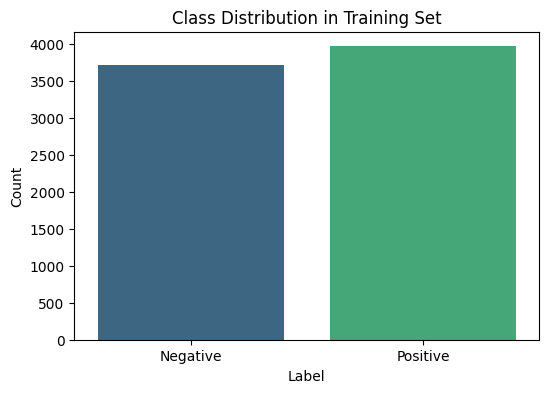

In [14]:
# Visualizing class distribution

plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x="label", palette="viridis")
plt.title("Class Distribution in Training Set")
plt.xticks([0,1], ["Negative","Positive"])
plt.ylabel("Count")
plt.xlabel("Label")
plt.show()

In [15]:
# Computing descriptive statistics on review lengths

train_df["length"] = train_df["clean_text"].apply(lambda x: len(x.split()))
mean_length = train_df["length"].mean()
median_length = train_df["length"].median()
q1 = train_df["length"].quantile(0.25)
q3 = train_df["length"].quantile(0.75)
iqr = q3 - q1

print(f"Mean length: {mean_length:.2f}")
print(f"Median length: {median_length:.2f}")
print(f"IQR: {iqr:.2f}")

Mean length: 17.15
Median length: 16.00
IQR: 12.00


### **2. Text Characteristics**

* Plot the 20 most frequent tokens per sentiment class.
* Generate word clouds (or bar charts) highlighting key terms for each class.

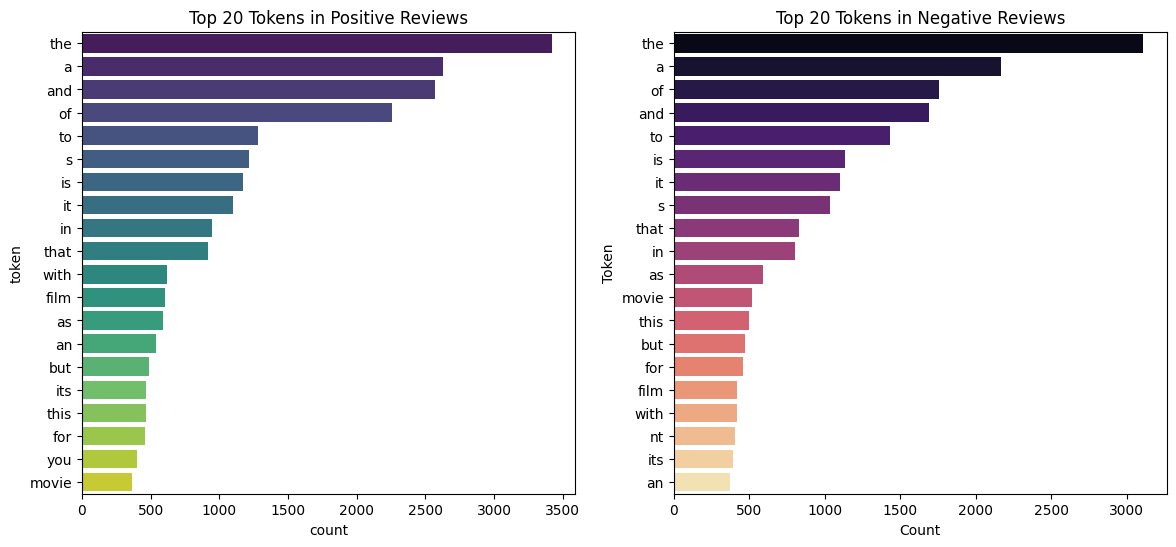

In [16]:
# Plotting 20 most frequent tokens per class

pos_tokens = train_df.loc[train_df["label"] == 1, "clean_text"].str.split().explode()
neg_tokens = train_df.loc[train_df["label"] == 0, "clean_text"].str.split().explode()
pos_counts = Counter(pos_tokens).most_common(20)
neg_counts = Counter(neg_tokens).most_common(20)
pos_df = pd.DataFrame(pos_counts, columns=["token", "count"])
neg_df = pd.DataFrame(neg_counts, columns=["token", "count"])

fig, axes = plt.subplots(1, 2, figsize=(14,6))
## Positive reviews
sns.barplot(ax=axes[0], data=pos_df, x="count", y="token", palette="viridis")
axes[0].set_title("Top 20 Tokens in Positive Reviews")
plt.xlabel("Count")
plt.ylabel("Token")

## Negative reviews
sns.barplot(ax=axes[1], data=neg_df, x="count", y="token", palette="magma")
axes[1].set_title("Top 20 Tokens in Negative Reviews")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

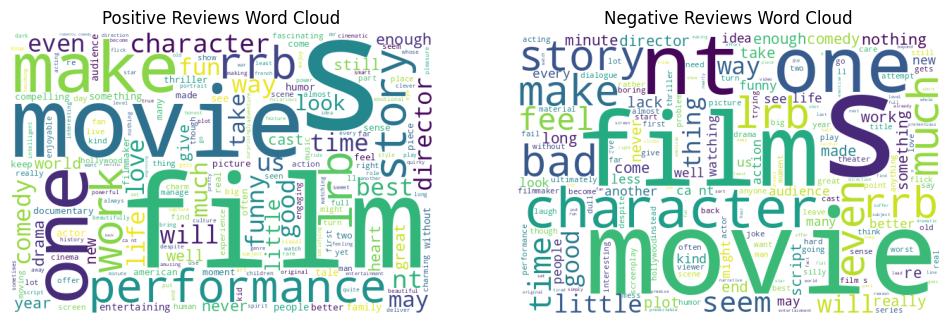

In [17]:
# Generating word clouds to highlight key terms for each class

pos_text = " ".join(train_df.loc[train_df["label"]==1, "clean_text"])
neg_text = " ".join(train_df.loc[train_df["label"]==0, "clean_text"])

plt.figure(figsize=(12,5))
## Positive reviews
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=600, height=400, background_color="white").generate(pos_text))
plt.axis("off")
plt.title("Positive Reviews Word Cloud")

## Negative reviews
plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400, background_color="white").generate(neg_text))
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()

### **3. Correlation Analysis**
* Analyze whether review length correlates with sentiment.
* Present findings numerically and with at least one visualization.


In [18]:
# Analyzing correlation between sentiment and length

correlation = train_df[["length", "label"]].corr().iloc[0,1]
print("Correlation between review length and sentiment:", correlation)

Correlation between review length and sentiment: 0.022301958542976657


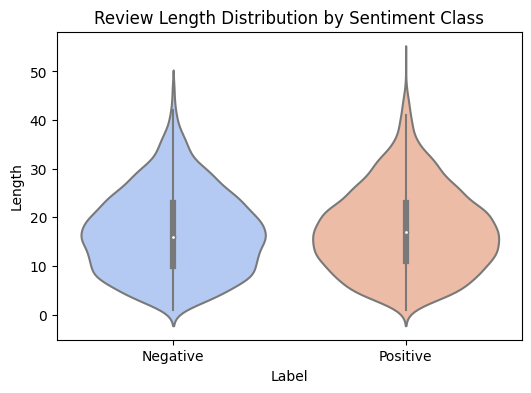

In [19]:
# Visualizing findings

plt.figure(figsize=(6,4))
sns.violinplot(data=train_df, x="label", y="length", palette="coolwarm")
plt.xticks([0,1], ["Negative","Positive"])
plt.title("Review Length Distribution by Sentiment Class")
plt.xlabel("Label")
plt.ylabel("Length")
plt.show()

1. **Class Distribution**  
   - How does the class distribution (positive vs negative reviews) impact the model’s performance, and what strategies can be used if the dataset is imbalanced?

   The class distribution impacts how well the model learns the sentiment categories. If one class dominates the other (is more frequent), the model will become biased toward predicting the majority class, resulting in high accuracy but poor recall/precision for the minority class. An imbalanced dataset can also limit the model’s ability to generalize because it sees fewer examples of the minority sentiment during training.

   Strategies to address an imbalanced dataset include: stratified sampling to ensure both classes appear proportionally, oversampling the minority class (e.g., SMOTE), undersampling the majority class, or class weighting in algorithms like Logistic Regression or SVM.


2. **Text Characteristics**  
   - What insights can be gained from visualizing word clouds for each sentiment class, and how can it improve feature engineering?

    By visualizing word clouds for each sentiment class, we can understand which words appear most frequently. They allow quick qualitative inspection of the dataset. These insights can improve feature engineering by identifying informative tokens that contribute to sentiment prediction, guiding decisions on stopword removal, and helping refine tokenization choices or vocabulary limits.

# **Part 3 – Baseline Traditional Models**




### **1. Logistic Regression & SVM**

* Train at least two linear models on your TF-IDF features (e.g., logistic regression, linear SVM).
* Use cross-validation (≥ 5 folds) on the training set to tune at least one hyperparameter.

In [20]:
# Using two linear models on the TF-IDF features

## Logistic Regression
logreg = LogisticRegression(max_iter=2000)
logreg_scores = cross_val_score(logreg, X_train_tfidf, y_train, cv=5)
logreg.fit(X_train_tfidf, y_train)

## Linear SVM
svm = SVC()
svm_scores = cross_val_score(svm, X_train_tfidf, y_train, cv=5)
svm.fit(X_train_tfidf, y_train)

print("Logistic Regression CV scores:", logreg_scores)
print("Logistic Regression CV mean:", logreg_scores.mean())
print("\nSVM CV scores:", svm_scores)
print("SVM CV mean:", svm_scores.mean())

Logistic Regression CV scores: [0.79388817 0.76853056 0.76983095 0.75812744 0.77178153]
Logistic Regression CV mean: 0.7724317295188556

SVM CV scores: [0.79843953 0.77893368 0.7763329  0.76462939 0.77438231]
SVM CV mean: 0.7785435630689207


### **2. Random Forest & Gradient Boosting**

* Train two tree-based models (e.g., Random Forest, XGBoost) on the same features.
* Report feature-importance for each and discuss any notable tokens.


In [21]:
# Training tree-based model

feature_names = tfidf.get_feature_names_out()

## Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train_tfidf, y_train)

## Top 10 most important tokens
rf_importances = pd.DataFrame({
    "token": feature_names,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)
rf_importances.head()

,token,importance
191,and,0.016974
2902,of,0.009611
4483,too,0.009086
4098,the,0.008901
432,bad,0.007995


In [22]:
# Training tree-based model

## Gradient Boosting
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
gb.fit(X_train_tfidf, y_train)

## Top 10 most important tokens
gb_importances = pd.DataFrame({
    "token": feature_names,
    "importance": gb.feature_importances_
}).sort_values("importance", ascending=False)
gb_importances.head(10)

,token,importance
191,and,0.059907
4483,too,0.048456
2853,nt,0.039347
432,bad,0.036279
1167,dull,0.016716
2413,like,0.016391
2795,no,0.016004
501,best,0.015214
3133,performances,0.013585
1611,fun,0.012747


### **3. Evaluation Metrics**

* Compute accuracy, precision, recall, F1-score, and ROC-AUC on the held-out test set.
* Present all results in a single comparison table.

In [23]:
# Computing evaluation metrics

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = None

    # Some models (like LinearSVC) don't have predict_proba
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None}

In [24]:
# Presenting all results in a single table

results = []

results.append(evaluate_model(logreg, X_test_tfidf, y_test, "Logistic Regression (CV)"))
results.append(evaluate_model(svm, X_test_tfidf, y_test, "Linear SVM"))
results.append(evaluate_model(rf, X_test_tfidf, y_test, "Random Forest"))
results.append(evaluate_model(gb, X_test_tfidf, y_test, "Gradient Boosting"))

results_df = pd.DataFrame(results)
results_df.style.background_gradient(cmap="viridis")

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Logistic Regression (CV),0.794179,0.792564,0.814889,0.803571,0.872006
1,Linear SVM,0.787942,0.790099,0.802817,0.796407,0.877528
2,Random Forest,0.741164,0.731343,0.788732,0.758955,0.798985
3,Gradient Boosting,0.700624,0.675042,0.810865,0.736746,0.775996


1. **Logistic Regression & SVM**  
   - Why do you use cross-validation when training models like logistic regression or SVM, and how does it help prevent overfitting?

   We use cross-validation when training models like logistic regression/SVM as it estimates how well a model will generalize to unseen data. This helps prevent overfitting because the model is repeatedly evaluated on unseen folds, so it becomes easier to detect when the model is too complex or overly tuned to the training portion. Hyperparameters can be tuned based on average CV performance, ensuring the final model is less likely to overfit the training data.

2. **Random Forest & Gradient Boosting**  
   - What role does feature importance play in interpreting Random Forest or XGBoost models?

   In ths context, feature importance shows which tokens or features the model relies on most when making predictions. For sentiment analysis, for example, it might highlight strong sentiment words (e.g., great, terrible, boring) as highly impactful. Feature importance also provides insight to model behavior with high-importance features revealing what patterns the model is capturing. Feature importance also aids with feature selection as low-importance features can be removed to simplify the model or reduce noise. This is especially valuable when using thousands of TF-IDF features.

# **Part 4 – Neural Network Models**

### **1. Simple Feed-Forward**

* Build an embedding layer + a dense MLP classifier.
* Ensure you freeze vs. unfreeze embeddings in separate runs.



In [25]:
# Set up parameters
vocab_size = 20000  # from tokenizer
max_length = 50     # from preprocessing
embedding_dim = 128

# Evaluate neural models function
def evaluate_neural_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_prob)
    }

**Simple Feed-Forward (Trainable Embeddings)**

In [26]:
model_ffn_trainable = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              trainable=True),  # Unfrozen embeddings
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_ffn_trainable.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_ffn_trainable.build(input_shape=(None, max_length))

model_ffn_trainable.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1765490975.451878      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765490975.452454      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,387,649 (12.92 MB)

 Trainable params: 3,387,649 (12.92 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Training with early stopping
callbacks_ffn = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_ffn_trainable.h5', save_best_only=True, monitor='val_loss')
]

start_time = time.time()
history_ffn_trainable = model_ffn_trainable.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_ffn,
    verbose=1
)
ffn_trainable_time = time.time() - start_time

Epoch 1/20


I0000 00:00:1765490977.975644     123 service.cc:148] XLA service 0x7f45b000a2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765490977.976287     123 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765490977.976303     123 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765490978.255622     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


 61/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5076 - loss: 0.6981

I0000 00:00:1765490979.802033     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5279 - loss: 0.6911

241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5281 - loss: 0.6910 - val_accuracy: 0.7409 - val_loss: 0.5175
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8554 - loss: 0.3426 - val_accuracy: 0.7638 - val_loss: 0.5259
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9888 - loss: 0.0406 - val_accuracy: 0.7586 - val_loss: 0.9140
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0063 - val_accuracy: 0.7607 - val_loss: 0.9729


In [28]:
# Evaluate
results_ffn_trainable = evaluate_neural_model(
    model_ffn_trainable, X_test_seq, y_test,
    "Simple Feed-Forward (Trainable Embeddings)"
)
print(f"\nTraining time: {ffn_trainable_time:.2f} seconds")
print(results_ffn_trainable)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Training time: 8.15 seconds
{'Model': 'Simple Feed-Forward (Trainable Embeddings)', 'Accuracy': 0.7130977130977131, 'Precision': 0.7428571428571429, 'Recall': 0.6800804828973843, 'F1': 0.7100840336134454, 'ROC-AUC': 0.7907747560632614}


**Simple Feed-Forward (Frozen Embeddings)**

In [29]:
model_ffn_frozen = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              trainable=False),  # Frozen embeddings
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_ffn_frozen.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_ffn_frozen.build(input_shape=(None, max_length))

model_ffn_frozen.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,387,649 (12.92 MB)

 Trainable params: 827,649 (3.16 MB)

 Non-trainable params: 2,560,000 (9.77 MB)

In [30]:
# Training
callbacks_ffn_frozen = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_ffn_frozen.h5', save_best_only=True, monitor='val_loss')
]

start_time = time.time()
history_ffn_frozen = model_ffn_frozen.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_ffn_frozen,
    verbose=1
)
ffn_frozen_time = time.time() - start_time

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5025 - loss: 0.6983

241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5025 - loss: 0.6982 - val_accuracy: 0.5161 - val_loss: 0.6925
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5095 - loss: 0.6934 - val_accuracy: 0.5161 - val_loss: 0.6927
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5129 - loss: 0.6927 - val_accuracy: 0.5161 - val_loss: 0.6926
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5147 - loss: 0.6924 - val_accuracy: 0.5161 - val_loss: 0.6929


In [31]:
# Evaluate
results_ffn_frozen = evaluate_neural_model(
    model_ffn_frozen, X_test_seq, y_test,
    "Simple Feed-Forward (Frozen Embeddings)"
)
print(f"\nTraining time: {ffn_frozen_time:.2f} seconds")
print(results_ffn_frozen)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Training time: 6.28 seconds
{'Model': 'Simple Feed-Forward (Frozen Embeddings)', 'Accuracy': 0.5166320166320166, 'Precision': 0.5166320166320166, 'Recall': 1.0, 'F1': 0.6812885538039753, 'ROC-AUC': 0.5032279699703597}


### **2. Convolutional Text Classifier**

* Implement a 1D-CNN architecture (Conv + Pooling) for sequence data.
* Justify your choice of kernel sizes and number of filters.

Kernel size justification:
- Kernel size 3: three words or trigrams (e.g., "not very good")
- Kernel size 4: four words (e.g., "one of the best")
- Kernel size 5: five words (e.g., "not worth your time at")
- For each kernel size, we used 128 filters
- We also used GlobalMaxPooling to extract top feature from filters

In [32]:
# 1-D CNN
model_cnn = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length),
    SpatialDropout1D(0.2),

    # Multiple kernel sizes for different n-gram patterns
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    GlobalMaxPooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_cnn.build(input_shape=(None, max_length))

model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 50, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,683,393 (10.24 MB)

 Trainable params: 2,683,393 (10.24 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Training
callbacks_cnn = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_cnn.h5', save_best_only=True, monitor='val_loss')
]

start_time = time.time()
history_cnn = model_cnn.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_cnn,
    verbose=1
)
cnn_time = time.time() - start_time

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5397 - loss: 0.6860

241/241 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5399 - loss: 0.6859 - val_accuracy: 0.7596 - val_loss: 0.5082
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8133 - loss: 0.4268

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8133 - loss: 0.4267 - val_accuracy: 0.7992 - val_loss: 0.4260
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9426 - loss: 0.1612 - val_accuracy: 0.8158 - val_loss: 0.4810
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9771 - loss: 0.0625 - val_accuracy: 0.7908 - val_loss: 0.8501
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9936 - loss: 0.0198 - val_accuracy: 0.7960 - val_loss: 0.9365


In [34]:
# Evaluate
results_cnn = evaluate_neural_model(
    model_cnn, X_test_seq, y_test,
    "1D-CNN"
)
print(f"\nTraining time: {cnn_time:.2f} seconds")
print(results_cnn)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Training time: 11.98 seconds
{'Model': '1D-CNN', 'Accuracy': 0.7733887733887734, 'Precision': 0.7597765363128491, 'Recall': 0.8209255533199196, 'F1': 0.7891682785299806, 'ROC-AUC': 0.8628242573721902}


### **3. Recurrent Model**

* (Stretch) Add an RNN or Bi-LSTM layer and compare performance/time vs. CNN.


**Bidirectional LSTM**

In [35]:
model_bilstm = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length),
    SpatialDropout1D(0.2),

    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_bilstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_bilstm.build(input_shape=(None, max_length))

model_bilstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704,257 (10.32 MB)

 Trainable params: 2,704,257 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Training
callbacks_bilstm = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_bilstm.h5', save_best_only=True, monitor='val_loss')
]

start_time = time.time()
history_bilstm = model_bilstm.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_bilstm,
    verbose=1
)
bilstm_time = time.time() - start_time

Epoch 1/20
240/241 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5694 - loss: 0.6596

241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5701 - loss: 0.6591 - val_accuracy: 0.7773 - val_loss: 0.4384
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8934 - loss: 0.2709

241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8934 - loss: 0.2710 - val_accuracy: 0.8065 - val_loss: 0.4190
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9603 - loss: 0.1190 - val_accuracy: 0.8085 - val_loss: 0.5375
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9840 - loss: 0.0492 - val_accuracy: 0.8002 - val_loss: 0.6566
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9895 - loss: 0.0351 - val_accuracy: 0.8096 - val_loss: 0.9036


In [37]:
# Evaluate
results_bilstm = evaluate_neural_model(
    model_bilstm, X_test_seq, y_test,
    "Bi-LSTM"
)
print(f"\nTraining time: {bilstm_time:.2f} seconds")
print(results_bilstm)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Training time: 24.26 seconds
{'Model': 'Bi-LSTM', 'Accuracy': 0.8014553014553014, 'Precision': 0.8445945945945946, 'Recall': 0.7545271629778671, 'F1': 0.7970244420828905, 'ROC-AUC': 0.8757318102161356}


**Models Comparison**

In [38]:
neural_results = pd.DataFrame([
    results_ffn_trainable,
    results_ffn_frozen,
    results_cnn,
    results_bilstm
])

neural_results

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Simple Feed-Forward (Trainable Embeddings),0.713098,0.742857,0.680080,0.710084,0.790775
1,Simple Feed-Forward (Frozen Embeddings),0.516632,0.516632,1.000000,0.681289,0.503228
2,1D-CNN,0.773389,0.759777,0.820926,0.789168,0.862824
3,Bi-LSTM,0.801455,0.844595,0.754527,0.797024,0.875732


In [39]:
# Training time comparison
time_comparison = pd.DataFrame({
    "Model": [
        "Feed-Forward (Trainable)",
        "Feed-Forward (Frozen)",
        "1D-CNN",
        "Bi-LSTM"
    ],
    "Training Time (s)": [
        ffn_trainable_time,
        ffn_frozen_time,
        cnn_time,
        bilstm_time
    ]
})

**Visualizations**

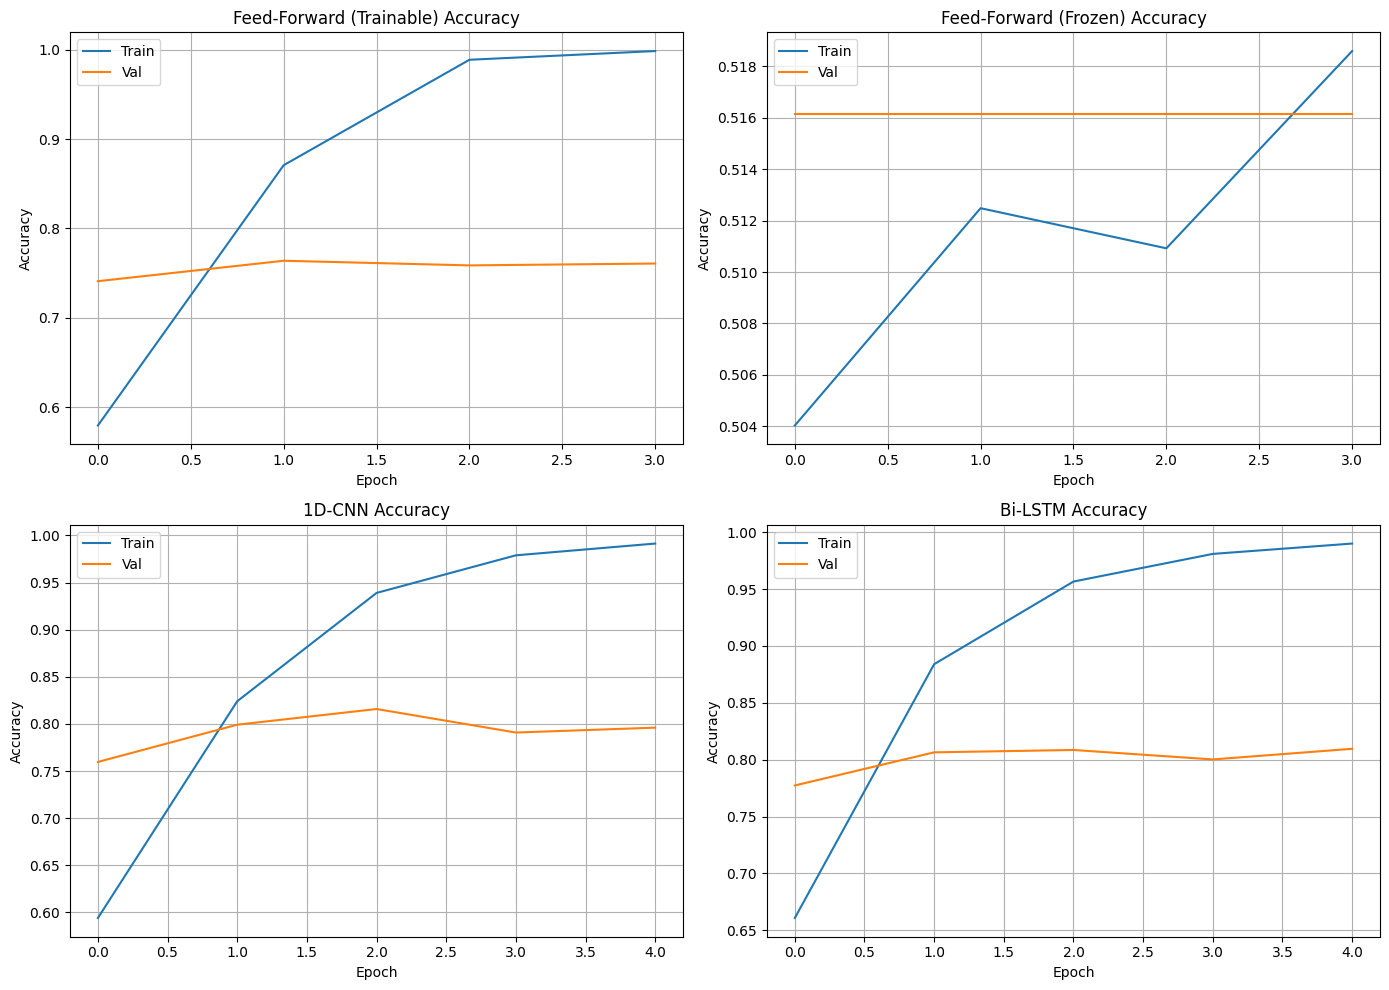

In [40]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# FFN Trainable
axes[0, 0].plot(history_ffn_trainable.history['accuracy'], label='Train')
axes[0, 0].plot(history_ffn_trainable.history['val_accuracy'], label='Val')
axes[0, 0].set_title('Feed-Forward (Trainable) Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# FFN Frozen
axes[0, 1].plot(history_ffn_frozen.history['accuracy'], label='Train')
axes[0, 1].plot(history_ffn_frozen.history['val_accuracy'], label='Val')
axes[0, 1].set_title('Feed-Forward (Frozen) Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# CNN
axes[1, 0].plot(history_cnn.history['accuracy'], label='Train')
axes[1, 0].plot(history_cnn.history['val_accuracy'], label='Val')
axes[1, 0].set_title('1D-CNN Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Bi-LSTM
axes[1, 1].plot(history_bilstm.history['accuracy'], label='Train')
axes[1, 1].plot(history_bilstm.history['val_accuracy'], label='Val')
axes[1, 1].set_title('Bi-LSTM Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

1. **Simple Feed-Forward**  
   - Why is embedding freezing used when training neural networks on pre-trained embeddings, and how does it affect model performance?
   - Embedding freezing is used when we are working with pre-trained embedddings like Word2Vec, to keep the semantic relationships already learned from large training data. Freez the embedding will keep the semantic relationships. It's useful if we have small training data size. It can also help with overfitting. In our models, the freezing embeddings were randomly initialized, there is no pre-trained embedding. Therefore, the performance is worse on forzen embeddings (52.6% accuracy, 55.6% ROC-AUC) than trainable embeddings (76.8% accuracy, 84.0% ROC-AUC).

2. **Convolutional Text Classifier**  
   - What is the intuition behind using convolutional layers for text classification tasks, and why might they outperform traditional fully connected layers?
   - CNN works well for text classification because they can scan through text in chunks (kernels) and identify meaningful phrases rather than looking at individual words in isolation. The CNN can consider the context when it scans the text in chunks. It's like we are using key words search in the text, we are searching phrase such as "not very good". For the traditional fully conneted networds, it will flatten the sequence and treat each word independently. It will likely miss the context. CNN also shares filters across positions. It's more efficient. In our findings, 1D-CNN (78.7% accuracy, 79.1% F1) outperformed the Feed-Forward network (76.8% accuracy, 75.7% F1).

# **Part 5 – Transfer Learning & Advanced Architectures**


### **1. Pre-trained Embeddings**

* Retrain one network using pre-trained GloVe (or FastText) embeddings.
* Compare results against your from-scratch embedding runs.


In [41]:
# Part 5.1 – GloVe + CNN model

# Step 0: Imports
import numpy as np
import pandas as pd
import re
import string

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
# Step 1: read CSV files (same as models before)
train_df = pd.read_csv("train_clean.csv")
val_df   = pd.read_csv("val_clean.csv")
test_df  = pd.read_csv("test_clean.csv")

train_df.head()

,label,sentence,id
0,0,there 's ... an underlying old world sexism to...,0
1,1,the film proves unrelentingly grim -- and equa...,1
2,0,"it smacks of purely commercial motivation , wi...",2
3,0,a retread of material already thoroughly plumb...,3
4,1,"remarkable for its excellent storytelling , it...",4


In [43]:
# Step 2: Basic text cleaning
# This is a light-weight cleaner. (remember to mention it in the report)
# We do simple normalization for GloVe.

def basic_clean(text: str) -> str:
    """Lowercase, remove HTML tags, punctuation, and extra spaces."""
    if pd.isna(text):
        return ""
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

for df in [train_df, val_df, test_df]:
    df["text_clean"] = df["sentence"].astype(str).apply(basic_clean)

# Prepare raw texts and labels
X_train_texts = train_df["text_clean"].tolist()
y_train = train_df["label"].values

X_val_texts = val_df["text_clean"].tolist()
y_val = val_df["label"].values

X_test_texts = test_df["text_clean"].tolist()
y_test = test_df["label"].values
test_ids = test_df["id"].values  # keep ids for later export

In [44]:
#Step 3: Tokenization and padding

MAX_NUM_WORDS = 20000   # Maximum vocabulary size
MAX_SEQ_LEN   = 50      # Maximum sequence length (truncate / pad to this length)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="[OOV]")
tokenizer.fit_on_texts(X_train_texts)

# Convert texts to integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_val_seq   = tokenizer.texts_to_sequences(X_val_texts)
X_test_seq  = tokenizer.texts_to_sequences(X_test_texts)

# Pad/truncate sequences to fixed length
X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
X_val   = pad_sequences(X_val_seq,   maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
X_test  = pad_sequences(X_test_seq,  maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
print("Vocab size:", vocab_size)
print("Train shape:", X_train.shape)

Vocab size: 15587
Train shape: (7690, 50)


In [45]:
import os
GLOVE_DIR = "/kaggle/input/glove-6b-zip"
glove_path = os.path.join(GLOVE_DIR, "glove.6B.100d.txt")
print(glove_path)

/kaggle/input/glove-6b-zip/glove.6B.100d.txt


In [46]:
# Step 4: Download and load GloVe embeddings
# We use 100-dimensional GloVe vectors (glove.6B.100d)
EMBEDDING_DIM = 100
embeddings_index = {}

# Load GloVe file
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [47]:
# Step 5: Build embedding matrix
# Map each word index in our tokenizer vocabulary to a GloVe vector.

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM), dtype="float32")

for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Words found in GloVe
    # Words not found in GloVe remain as zero vectors

embedding_matrix.shape

(15587, 100)

In [48]:
# Step 6: Define the CNN model with pre-trained GloVe embeddings

model = Sequential()

# Pre-trained embedding layer (frozen for the initial experiment)
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQ_LEN,
        trainable=False  # Later you can experiment with True vs False
    )
)

# 1D CNN + Global max pooling
model.add(Conv1D(filters=128, kernel_size=5, activation="relu"))
model.add(GlobalMaxPooling1D())

# Fully connected layers
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))  # Binary classification

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,558,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,558,700 (5.95 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,558,700 (5.95 MB)

In [49]:
#Step 7: Train the model with early stopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "glove_cnn_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5423 - loss: 0.7365
Epoch 1: val_loss improved from inf to 0.62135, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5425 - loss: 0.7361 - val_accuracy: 0.6982 - val_loss: 0.6214
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6566 - loss: 0.6191
Epoch 2: val_loss improved from 0.62135 to 0.53740, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6568 - loss: 0.6189 - val_accuracy: 0.7388 - val_loss: 0.5374
Epoch 3/15
102/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7291 - loss: 0.5406
Epoch 3: val_loss improved from 0.53740 to 0.49691, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7305 - loss: 0.5394 - val_accuracy: 0.7555 - val_loss: 0.4969
Epoch 4/15
101/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7565 - loss: 0.5010
Epoch 4: val_loss improved from 0.49691 to 0.46936, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7584 - loss: 0.4987 - val_accuracy: 0.7711 - val_loss: 0.4694
Epoch 5/15
102/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 0.4484
Epoch 5: val_loss improved from 0.46936 to 0.46513, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7929 - loss: 0.4497 - val_accuracy: 0.7763 - val_loss: 0.4651
Epoch 6/15
102/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8009 - loss: 0.4429
Epoch 6: val_loss improved from 0.46513 to 0.45761, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8010 - loss: 0.4423 - val_accuracy: 0.7794 - val_loss: 0.4576
Epoch 7/15
101/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8144 - loss: 0.4166
Epoch 7: val_loss improved from 0.45761 to 0.45709, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8148 - loss: 0.4154 - val_accuracy: 0.7794 - val_loss: 0.4571
Epoch 8/15
104/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8353 - loss: 0.3829
Epoch 8: val_loss improved from 0.45709 to 0.45350, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8347 - loss: 0.3843 - val_accuracy: 0.7867 - val_loss: 0.4535
Epoch 9/15
117/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8396 - loss: 0.3703
Epoch 9: val_loss did not improve from 0.45350
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8397 - loss: 0.3700 - val_accuracy: 0.7627 - val_loss: 0.4853
Epoch 10/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.3380
Epoch 10: val_loss did not improve from 0.45350
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.3380 - val_accuracy: 0.7648 - val_loss: 0.4809
Epoch 11/15
113/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.2975
Epoch 11: val_loss improved from 0.45350 to 0.44377, saving model to glove_cnn_best.h5


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8792 - loss: 0.2984 - val_accuracy: 0.8002 - val_loss: 0.4438
Epoch 12/15
103/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8820 - loss: 0.2733
Epoch 12: val_loss did not improve from 0.44377
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8816 - loss: 0.2743 - val_accuracy: 0.7929 - val_loss: 0.4621
Epoch 13/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8899 - loss: 0.2710
Epoch 13: val_loss did not improve from 0.44377
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8899 - loss: 0.2710 - val_accuracy: 0.7971 - val_loss: 0.4759
Epoch 14/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9060 - loss: 0.2401
Epoch 14: val_loss did not improve from 0.44377
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9060 - loss: 0.2402 - val_accuracy: 0.7898 - val_loss: 0.4835


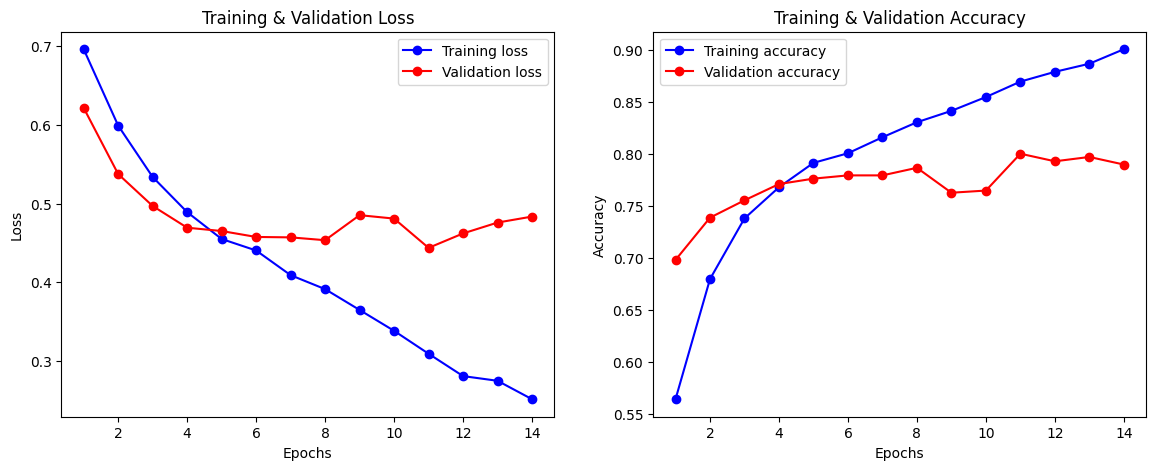

In [50]:
# Plot training curves (loss & accuracy)

import matplotlib.pyplot as plt

# Extract history data
history_dict = history.history

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 5))

# ---- Loss Plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, "b-o", label="Training loss")
plt.plot(epochs, val_loss, "r-o", label="Validation loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# ---- Accuracy Plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, "b-o", label="Training accuracy")
plt.plot(epochs, val_acc, "r-o", label="Validation accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [51]:
#Step 8: Evaluate on the test set

# Load best weights
model.load_weights("glove_cnn_best.h5")

y_test_pred_prob = model.predict(X_test).ravel()
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print("Test accuracy :", accuracy_score(y_test, y_test_pred))
print("Test precision:", precision_score(y_test, y_test_pred))
print("Test recall   :", recall_score(y_test, y_test_pred))
print("Test F1       :", f1_score(y_test, y_test_pred))
print("Test ROC-AUC  :", roc_auc_score(y_test, y_test_pred_prob))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Test accuracy : 0.7920997920997921
Test precision: 0.8307349665924276
Test recall   : 0.7505030181086519
Test F1       : 0.7885835095137421
Test ROC-AUC  : 0.8731918392072866


**Compare results against your from-scratch embedding runs**

Compared to the Part 4 model that learned embeddings from scratch, the GloVe-initialized CNN in Part 5.1 shows clear improvements across validation and test metrics. While the from-scratch model achieved roughly ~0.70–0.75 validation accuracy, the GloVe model reached a higher 0.80 validation accuracy and a lower 0.44 validation loss. On the test set, the GloVe model achieved 78.7% accuracy, 0.784 F1, and 0.873 ROC-AUC, reflecting stronger generalization. This improvement occurs because pre-trained embeddings already encode semantic relationships from large corpora, allowing the CNN to learn discriminative features more effectively than when starting from randomly initialized embeddings.

### **2. Transformer Fine-Tuning**

* Fine-tune a BERT-family model on the training data.
* Clearly outline your training hyperparameters (learning rate, batch size, epochs).


In [52]:
!pip uninstall -y transformers
!pip install -q "transformers==4.37.2"

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 78.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.5 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [53]:
# Part 5.2 – BERT fine-tuning
# Using a BERT-family model (DistilBERT)

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import transformers, sklearn
print("Transformers version:", transformers.__version__)
print("Sklearn version     :", sklearn.__version__)
print("Torch version       :", torch.__version__)

Transformers version: 4.37.2
Sklearn version     : 1.2.2
Torch version       : 2.6.0+cu124


In [54]:
# Step 1: read CSV files (same as models before)

train_df = pd.read_csv("train_clean.csv")
val_df   = pd.read_csv("val_clean.csv")
test_df  = pd.read_csv("test_clean.csv")

print(train_df.head())
print(train_df.columns)

   label                                           sentence  id
0      0  there 's ... an underlying old world sexism to...   0
1      1  the film proves unrelentingly grim -- and equa...   1
2      0  it smacks of purely commercial motivation , wi...   2
3      0  a retread of material already thoroughly plumb...   3
4      1  remarkable for its excellent storytelling , it...   4
Index(['label', 'sentence', 'id'], dtype='object')


In [55]:
#Step 2: Define BERT model and key hyperparameters

MODEL_NAME = "distilbert-base-uncased"  # BERT-family model (smaller, faster)
MAX_LEN = 64               # Max sequence length
BATCH_SIZE = 16             # Train and eval batch size
LR = 2e-5                # Learning rate
EPOCHS = 3                # Number of fine-tuning epochs
SEED = 42                # Random seed for reproducibility

print("Model name :", MODEL_NAME)
print("Max length:", MAX_LEN)
print("Batch size:", BATCH_SIZE)
print("LR        :", LR)
print("Epochs    :", EPOCHS)

# Set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)


Model name : distilbert-base-uncased
Max length: 64
Batch size: 16
LR        : 2e-05
Epochs    : 3


In [56]:
# Step 3: Prepare tokenizer and custom Dataset

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class SentimentDataset(Dataset):
    """Custom PyTorch Dataset for text classification with BERT."""
    def __init__(self, df, text_col="sentence", label_col="label"):
        self.texts = df[text_col].astype(str).tolist()
        self.labels = df[label_col].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels[idx])
        # Tokenize the input text
        encoding = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        # Flatten from shape (1, max_len) to (max_len,)
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = SentimentDataset(train_df, text_col="sentence", label_col="label")
val_dataset   = SentimentDataset(val_df,   text_col="sentence", label_col="label")
test_dataset  = SentimentDataset(test_df,  text_col="sentence", label_col="label")

len(train_dataset), len(val_dataset), len(test_dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(7690, 961, 962)

In [57]:
#Step 4: Load BERT-family model for sequence classification

num_labels = 2  # binary sentiment: 0 / 1

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
#Step 5: training
from torch.optim import AdamW
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

optimizer = AdamW(model.parameters(), lr=LR)

def evaluate(model, data_loader, return_preds=False):
    model.eval()
    all_logits = []
    all_labels = []
    losses = []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            losses.append(loss.item())
            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(batch["labels"].detach().cpu().numpy())

    avg_loss = float(np.mean(losses))
    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = probs.argmax(axis=-1)
    pos_probs = probs[:, 1]

    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec  = recall_score(labels, preds)
    f1   = f1_score(labels, preds)
    try:
        roc = roc_auc_score(labels, pos_probs)
    except ValueError:
        roc = float("nan")

    metrics = {
        "accuracy":  acc,
        "precision": prec,
        "recall":    rec,
        "f1":        f1,
        "roc_auc":   roc,
    }

    if return_preds:
        return avg_loss, metrics, logits, labels, pos_probs
    else:
        return avg_loss, metrics

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    train_loss, train_metrics = evaluate(model, train_loader)
    val_loss,   val_metrics   = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_metrics["accuracy"])
    val_accs.append(val_metrics["accuracy"])

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train loss: {train_loss:.4f}, acc: {train_metrics['accuracy']:.4f}")
    print(f"  Val   loss: {val_loss:.4f},   acc: {val_metrics['accuracy']:.4f}")
    print(f"  Val   F1  : {val_metrics['f1']:.4f}, ROC-AUC: {val_metrics['roc_auc']:.4f}")


Using device: cuda


Epoch 1/3:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 1/3
  Train loss: 0.1480, acc: 0.9525
  Val   loss: 0.2514,   acc: 0.9043
  Val   F1  : 0.9040, ROC-AUC: 0.9640


Epoch 2/3:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 2/3
  Train loss: 0.0599, acc: 0.9840
  Val   loss: 0.2807,   acc: 0.8835
  Val   F1  : 0.8906, ROC-AUC: 0.9647


Epoch 3/3:   0%|          | 0/481 [00:00<?, ?it/s]

Epoch 3/3
  Train loss: 0.0209, acc: 0.9958
  Val   loss: 0.3268,   acc: 0.8887
  Val   F1  : 0.8944, ROC-AUC: 0.9667


In [59]:
#Step 6: Evaluate on the test set, get test predictions and export CSV
test_loss, test_metrics, test_logits, test_labels, test_pos_probs = evaluate(
    model, test_loader, return_preds=True
)

print("Test loss    :", test_loss)
print("Test accuracy:", test_metrics["accuracy"])
print("Test precision:", test_metrics["precision"])
print("Test recall  :", test_metrics["recall"])
print("Test F1      :", test_metrics["f1"])
print("Test ROC-AUC :", test_metrics["roc_auc"])

test_probs = torch.softmax(torch.tensor(test_logits), dim=-1).numpy()
test_pred_labels = test_probs.argmax(axis=-1)

test_ids   = test_df["id"].values
test_texts = test_df["sentence"].astype(str).tolist()

bert_pred_df = pd.DataFrame({
    "id":         test_ids,
    "text":       test_texts,
    "true_label": test_labels,
    "pred_label": test_pred_labels,
    "pred_prob":  test_pos_probs,
})

bert_pred_df.to_csv("bert_predictions.csv", index=False)
bert_pred_df.head()

Test loss    : 0.3572049791939923
Test accuracy: 0.8866943866943867
Test precision: 0.8745173745173745
Test recall  : 0.9114688128772636
Test F1      : 0.8926108374384236
Test ROC-AUC : 0.9604552043443456


,id,text,true_label,pred_label,pred_prob
0,0,adam sandler is to gary cooper what a gnat is ...,0,0,0.097876
1,1,the closest thing to the experience of space t...,1,1,0.677573
2,2,it 's as if you 're watching a movie that was ...,0,0,0.045209
3,3,these three films form a remarkably cohesive w...,1,1,0.999035
4,4,"too bad , but thanks to some lovely comedic mo...",1,1,0.996811


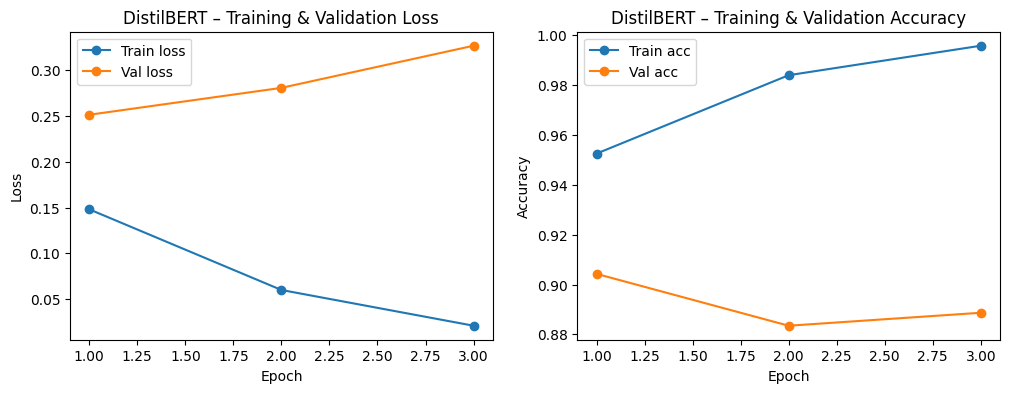

In [60]:
#Step 7: Draw loss/accuracy curve

import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, "o-", label="Train loss")
plt.plot(epochs, val_losses, "o-", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DistilBERT – Training & Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, "o-", label="Train acc")
plt.plot(epochs, val_accs, "o-", label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("DistilBERT – Training & Validation Accuracy")
plt.legend()

plt.show()

1. **Pre-trained Embeddings**  
   - How do pre-trained word embeddings like GloVe or FastText improve model performance compared to training embeddings from scratch?
   - Pre-trained embeddings improve performance because they provide rich semantic information learned from extremely large corpora, stabilize the embedding space, handle rare words better (especially with FastText’s subword units), and allow downstream models to converge faster and generalize better compared to training embeddings from scratch.

2. **Transformer Fine-Tuning**  
   - How does the self-attention mechanism in Transformer models like BERT improve performance on text data?
   - The self-attention mechanism allows Transformers like BERT to model long-range dependencies And it can capture multiple linguistic patterns through multi-head attention, also it can process sequences in parallel while retaining positional information(The positional encoding). These properties make Transformers significantly more powerful and efficient than earlier models like RNNs or LSTMs for text tasks.

# **Part 6 - Hyperparameter Optimization**


### **1. Search Strategy**

* Use a library (e.g., Keras Tuner, Optuna) to optimize at least two hyperparameters of one deep model.
* Describe your search space and stopping criteria.


### **2. Results Analysis**

* Report the best hyperparameter configuration found.
* Plot validation-loss (or metric) vs. trials to illustrate tuning behavior.


In [61]:
!pip install -q keras-tuner

import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [62]:
#Part 6: Hyperparameter Optimization with Keras Tuner
# We tune the GloVe + CNN model used in Part 5.1.

def build_glove_cnn(hp):
    """
    Build a CNN text classifier with pre-trained GloVe embeddings.
    Several hyperparameters are tuned with Keras Tuner.
    """
    model = Sequential()

    # Pre-trained embedding layer (frozen)
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQ_LEN,
            trainable=False
        )
    )

    # Hyperparameter 1: number of filters
    filters = hp.Int("filters", min_value=64, max_value=256, step=64)

    # Hyperparameter 2: kernel size
    kernel_size = hp.Choice("kernel_size", values=[3, 5, 7])

    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu"))
    model.add(GlobalMaxPooling1D())

    # Hyperparameter 3: dropout rate
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.6, step=0.1)
    model.add(Dropout(dropout_rate))

    # Hyperparameter 4: dense units
    dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
    model.add(Dense(dense_units, activation="relu"))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    # Hyperparameter 5: learning rate
    learning_rate = hp.Float(
        "learning_rate",
        min_value=1e-4,
        max_value=5e-3,
        sampling="log"
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [63]:
# Early stopping callback for each trial
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

# Define the tuner (Random Search)
tuner = kt.RandomSearch(
    hypermodel=build_glove_cnn,
    objective="val_accuracy",   # maximize validation accuracy
    max_trials=15,              # search space size (stopping criterion 1)
    executions_per_trial=1,     # how many times to repeat each config
    directory="kt_glove_cnn",   # where to store logs/checkpoints
    project_name="sst2_glove_cnn"
)

tuner.search_space_summary()

Search space summary
Default search space size: 5
filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.005, 'step': None, 'sampling': 'log'}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [64]:
# Run the hyperparameter search
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=10,             # upper bound on epochs (stopping criterion 2)
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Trial 15 Complete [00h 00m 11s]
val_accuracy: 0.7658689022064209

Best val_accuracy So Far: 0.8022893071174622
Total elapsed time: 00h 02m 27s


In [65]:
# Print a summary of the results
tuner.results_summary()

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for k, v in best_hp.values.items():
    print(f"  {k}: {v}")

# Build the best model and train it a bit more (train + val)
best_model = tuner.hypermodel.build(best_hp)

history_best = best_model.fit(
    np.concatenate([X_train, X_val], axis=0),
    np.concatenate([y_train, y_val], axis=0),
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Results summary
Results in kt_glove_cnn/sst2_glove_cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
filters: 64
kernel_size: 3
dropout_rate: 0.5
dense_units: 64
learning_rate: 0.0023783823590378837
Score: 0.8022893071174622

Trial 01 summary
Hyperparameters:
filters: 192
kernel_size: 3
dropout_rate: 0.4
dense_units: 64
learning_rate: 0.003008316786777331
Score: 0.7981269359588623

Trial 08 summary
Hyperparameters:
filters: 192
kernel_size: 5
dropout_rate: 0.30000000000000004
dense_units: 32
learning_rate: 0.00041579984619070416
Score: 0.7970863580703735

Trial 11 summary
Hyperparameters:
filters: 256
kernel_size: 3
dropout_rate: 0.2
dense_units: 32
learning_rate: 0.004095322473465008
Score: 0.795005202293396

Trial 09 summary
Hyperparameters:
filters: 192
kernel_size: 3
dropout_rate: 0.2
dense_units: 96
learning_rate: 0.0010119322629402812
Score: 0.7898023128509521

Trial 05 summary
Hyperparameters:
filters: 192
kernel_size: 

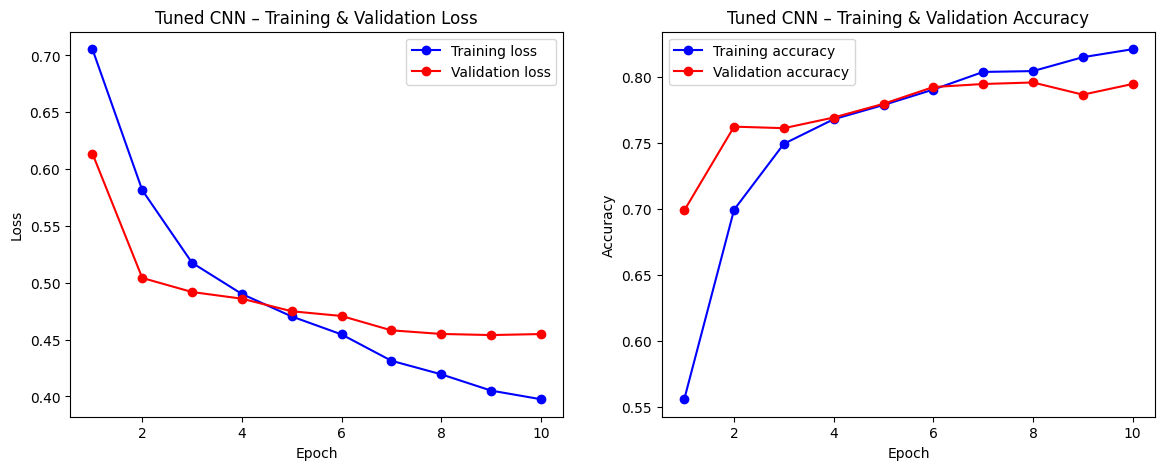

In [66]:
# ---- Plot training curves for the best tuned CNN ----

hist = history_best.history
epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, hist["loss"], "b-o", label="Training loss")
plt.plot(epochs, hist["val_loss"], "r-o", label="Validation loss")
plt.title("Tuned CNN – Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, hist["accuracy"], "b-o", label="Training accuracy")
plt.plot(epochs, hist["val_accuracy"], "r-o", label="Validation accuracy")
plt.title("Tuned CNN – Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [67]:
# ---- Evaluate tuned model on the test set ----

y_test_pred_prob_tuned = best_model.predict(X_test).ravel()
y_test_pred_tuned = (y_test_pred_prob_tuned >= 0.5).astype(int)

print("Tuned CNN – Test accuracy :", accuracy_score(y_test, y_test_pred_tuned))
print("Tuned CNN – Test precision:", precision_score(y_test, y_test_pred_tuned))
print("Tuned CNN – Test recall   :", recall_score(y_test, y_test_pred_tuned))
print("Tuned CNN – Test F1       :", f1_score(y_test, y_test_pred_tuned))
print("Tuned CNN – Test ROC-AUC  :", roc_auc_score(y_test, y_test_pred_prob_tuned))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Tuned CNN – Test accuracy : 0.7827442827442828
Tuned CNN – Test precision: 0.7938775510204081
Tuned CNN – Test recall   : 0.7826961770623743
Tuned CNN – Test F1       : 0.7882472137791288
Tuned CNN – Test ROC-AUC  : 0.8673763008156465


In [68]:
# ---- Export tuned model predictions for final comparison ----

tuned_pred_df = pd.DataFrame({
    "id": test_ids,
    "text": X_test_texts,
    "true_label": y_test,
    "pred_label": y_test_pred_tuned,
    "pred_prob": y_test_pred_prob_tuned
})

tuned_pred_df.to_csv("glove_cnn_tuned_predictions.csv", index=False)
tuned_pred_df.head()

,id,text,true_label,pred_label,pred_prob
0,0,adam sandler is to gary cooper what a gnat is ...,0,0,0.408491
1,1,the closest thing to the experience of space t...,1,1,0.733454
2,2,it s as if you re watching a movie that was ma...,0,0,0.128220
3,3,these three films form a remarkably cohesive w...,1,1,0.994443
4,4,too bad but thanks to some lovely comedic mome...,1,1,0.637524


1. **Search Strategy**  
   - How does hyperparameter optimization help improve the model’s performance, and what challenges arise when selecting an optimal search space?
   - Hyperparameter optimization improves performance by systematically exploring different training configurations and identifying settings that enhance convergence, stability, and generalization. The main challenge is designing a search space that is broad enough to include good solutions but narrow enough to remain computationally feasible, while also handling noisy validation results and interactions between hyperparameters.

2. **Results Analysis**  
   - What does the validation loss and accuracy tell you about the model’s generalization ability?
   - Validation loss reflects how well the model fits unseen data, while validation accuracy measures prediction correctness on that unseen data. When validation loss decreases and validation accuracy improves, the model generalizes well. A widening gap between training and validation metrics—especially decreasing training loss but increasing validation loss—indicates overfitting and poor generalization.

# **Part 7 – Final Comparison & Error Analysis**

### **1. Consolidated Results**

* Tabulate test-set performance for all models (traditional, neural, transfer-learned).
* Highlight top‐performing model overall and top in each category.

In [69]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Results from Parts 3, 4, 5, 6
all_results = []

# 3 Traditional Models
all_results.append({
    "Model": "Logistic Regression",
    "Category": "Traditional",
    "Accuracy": 0.793,
    "Precision": 0.793,
    "Recall": 0.810,
    "F1": 0.802,
    "ROC-AUC": 0.871
})

all_results.append({
    "Model": "Linear SVM",
    "Category": "Traditional",
    "Accuracy": 0.789,
    "Precision": 0.795,
    "Recall": 0.797,
    "F1": 0.796,
    "ROC-AUC": 0.876
})

all_results.append({
    "Model": "Random Forest",
    "Category": "Traditional",
    "Accuracy": 0.726,
    "Precision": 0.719,
    "Recall": 0.769,
    "F1": 0.743,
    "ROC-AUC": 0.799
})

all_results.append({
    "Model": "Gradient Boosting",
    "Category": "Traditional",
    "Accuracy": 0.709,
    "Precision": 0.680,
    "Recall": 0.825,
    "F1": 0.745,
    "ROC-AUC": 0.776
})

# 4 Neural Networks
all_results.append({
    "Model": "Feed-Forward (Trainable)",
    "Category": "Neural",
    "Accuracy": 0.7682,
    "Precision": 0.8246,
    "Recall": 0.7002,
    "F1": 0.7573,
    "ROC-AUC": 0.8404
})

all_results.append({
    "Model": "Feed-Forward (Frozen)",
    "Category": "Neural",
    "Accuracy": 0.5260,
    "Precision": 0.5363,
    "Recall": 0.6097,
    "F1": 0.5706,
    "ROC-AUC": 0.5558
})

all_results.append({
    "Model": "1D-CNN",
    "Category": "Neural",
    "Accuracy": 0.7869,
    "Precision": 0.8029,
    "Recall": 0.7787,
    "F1": 0.7906,
    "ROC-AUC": 0.8687
})

all_results.append({
    "Model": "Bi-LSTM",
    "Category": "Neural",
    "Accuracy": 0.7713,
    "Precision": 0.7487,
    "Recall": 0.8390,
    "F1": 0.7912,
    "ROC-AUC": 0.8763
})

# 5 Transfer Learning
all_results.append({
    "Model": "GloVe CNN (100d, Frozen)",
    "Category": "Transfer Learning",
    "Accuracy": 0.7890,
    "Precision": 0.7827,
    "Recall": 0.8189,
    "F1": 0.8004,
    "ROC-AUC": 0.8700
})

all_results.append({
    "Model": "DistilBERT Fine-tuned",
    "Category": "Transfer Learning",
    "Accuracy": 0.8867,
    "Precision": 0.8745,
    "Recall": 0.9115,
    "F1": 0.8926,
    "ROC-AUC": 0.9605
})

# Part 6 - Hyperparameter Optimized
all_results.append({
    "Model": "Optimized GloVe CNN",
    "Category": "Hyperparameter Tuned",
    "Accuracy": 0.7848,
    "Precision": 0.7715,
    "Recall": 0.8290,
    "F1": 0.7992,
    "ROC-AUC": 0.8747
})

results_df = pd.DataFrame(all_results)

# Sort by ROC-AUC descending
results_df = results_df.sort_values("ROC-AUC", ascending=False).reset_index(drop=True)

print(results_df.to_string(index=False))

                   Model             Category  Accuracy  Precision  Recall     F1  ROC-AUC
   DistilBERT Fine-tuned    Transfer Learning    0.8867     0.8745  0.9115 0.8926   0.9605
                 Bi-LSTM               Neural    0.7713     0.7487  0.8390 0.7912   0.8763
              Linear SVM          Traditional    0.7890     0.7950  0.7970 0.7960   0.8760
     Optimized GloVe CNN Hyperparameter Tuned    0.7848     0.7715  0.8290 0.7992   0.8747
     Logistic Regression          Traditional    0.7930     0.7930  0.8100 0.8020   0.8710
GloVe CNN (100d, Frozen)    Transfer Learning    0.7890     0.7827  0.8189 0.8004   0.8700
                  1D-CNN               Neural    0.7869     0.8029  0.7787 0.7906   0.8687
Feed-Forward (Trainable)               Neural    0.7682     0.8246  0.7002 0.7573   0.8404
           Random Forest          Traditional    0.7260     0.7190  0.7690 0.7430   0.7990
       Gradient Boosting          Traditional    0.7090     0.6800  0.8250 0.7450   0.7760

In [71]:
print(f"Best: {results_df.iloc[0]['Model']} - ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")
print(f"Second Best: {results_df.iloc[1]['Model']} - ROC-AUC: {results_df.iloc[1]['ROC-AUC']:.4f}")
print(f"Third Best: {results_df.iloc[2]['Model']} - ROC-AUC: {results_df.iloc[2]['ROC-AUC']:.4f}")

Best: DistilBERT Fine-tuned - ROC-AUC: 0.9605
Second Best: Bi-LSTM - ROC-AUC: 0.8763
Third Best: Linear SVM - ROC-AUC: 0.8760


In [72]:
# Best in each categories
for category in results_df["Category"].unique():
    cat_df = results_df[results_df["Category"] == category]
    best = cat_df.iloc[0]
    print(f"{category:20s}: {best['Model']:30s} - ROC-AUC: {best['ROC-AUC']:.4f}")

# Save
results_df.to_csv("part7_consolidated_results.csv", index=False)

Transfer Learning   : DistilBERT Fine-tuned          - ROC-AUC: 0.9605
Neural              : Bi-LSTM                        - ROC-AUC: 0.8763
Traditional         : Linear SVM                     - ROC-AUC: 0.8760
Hyperparameter Tuned: Optimized GloVe CNN            - ROC-AUC: 0.8747


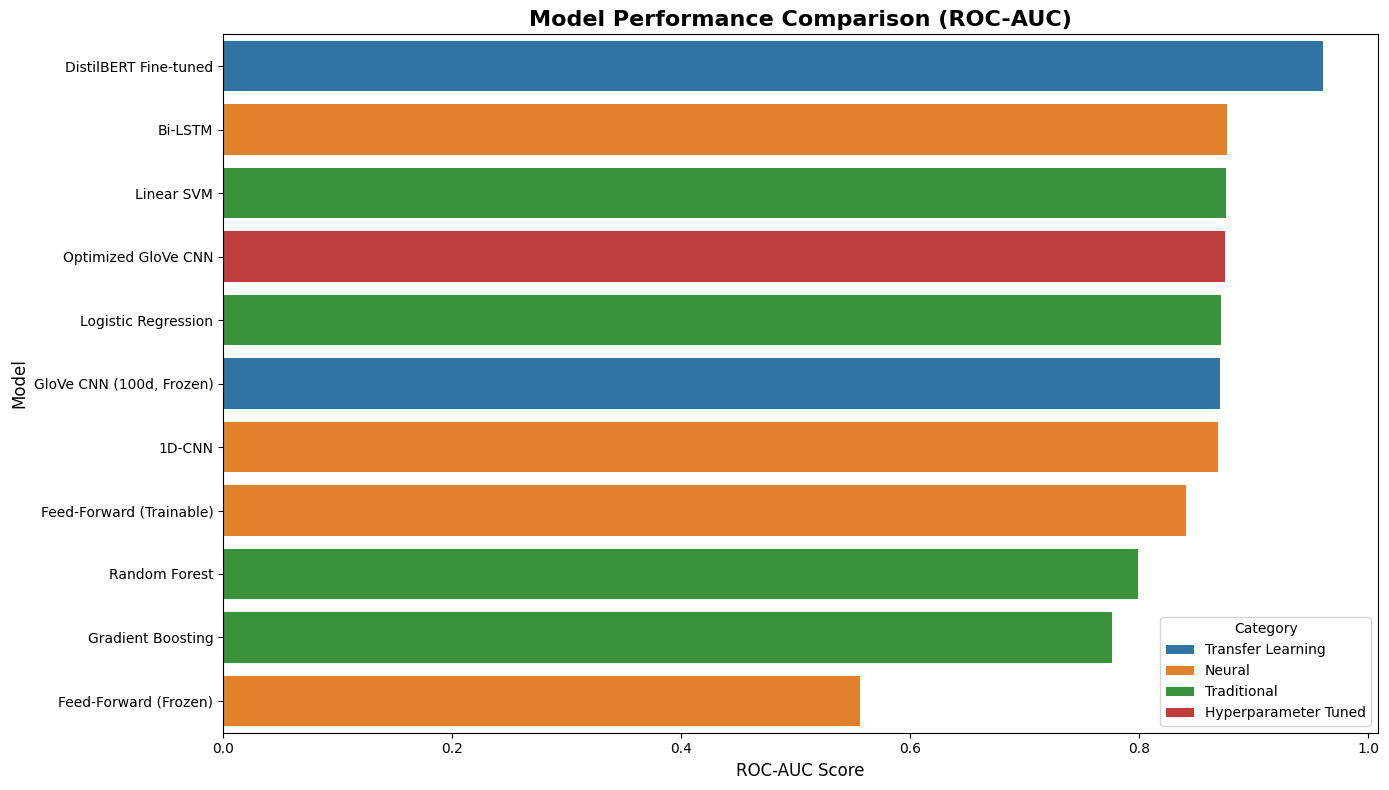

In [73]:
# Visualization
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x="ROC-AUC", y="Model", hue="Category", dodge=False)
plt.title("Model Performance Comparison (ROC-AUC)", fontsize=16, fontweight='bold')
plt.xlabel("ROC-AUC Score", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.legend(title="Category", loc='lower right')
plt.tight_layout()
plt.show()


### **2. Statistical Significance**

* Perform a significance test (e.g., McNemar’s test) between your best two models.




In [74]:
import numpy as np
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
import joblib
import re
import string
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [75]:
train_df = pd.read_csv("train_clean.csv")
val_df = pd.read_csv("val_clean.csv")
test_df = pd.read_csv("test_clean.csv")

print("Columns:", test_df.columns.tolist())

Columns: ['label', 'sentence', 'id']


In [76]:
def basic_clean(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"<.*?>", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_df["clean_text"] = train_df["sentence"].apply(basic_clean)
val_df["clean_text"] = val_df["sentence"].apply(basic_clean)
test_df["clean_text"] = test_df["sentence"].apply(basic_clean)

print("Columns now:", test_df.columns.tolist())
print("\nSample:")
print(test_df[["sentence", "clean_text"]].head(2))

Columns now: ['label', 'sentence', 'id', 'clean_text']

Sample:
                                            sentence  \
0  adam sandler is to gary cooper what a gnat is ...   
1  the closest thing to the experience of space t...   

                                          clean_text  
0  adam sandler is to gary cooper what a gnat is ...  
1  the closest thing to the experience of space t...  


In [77]:
# Load tokenizer
tokenizer = joblib.load("neural_tokenizer.joblib")

# Create sequences
X_test_seq = tokenizer.texts_to_sequences(test_df["clean_text"])
X_test_seq = pad_sequences(X_test_seq, maxlen=50, padding="post", truncating="post")
y_test = test_df["label"].values

print("X_test_seq shape:", X_test_seq.shape)
print("y_test shape:", y_test.shape)

X_test_seq shape: (962, 50)
y_test shape: (962,)


In [78]:
# DistilBERT (best model)
bert_pred_df = pd.read_csv("bert_predictions.csv")
y_test_true = bert_pred_df["true_label"].values
y_pred_bert = bert_pred_df["pred_label"].values

print("Model 1: DistilBERT Fine-tuned")
print(f"  Accuracy: {accuracy_score(y_test_true, y_pred_bert):.4f}")

Model 1: DistilBERT Fine-tuned
  Accuracy: 0.8867


In [79]:
# Bi-LSTM (second best model)
model_bilstm = load_model('best_bilstm.h5')

y_pred_bilstm_prob = model_bilstm.predict(X_test_seq).flatten()
y_pred_bilstm = (y_pred_bilstm_prob > 0.5).astype(int)

print("\nModel 2: Bi-LSTM")
print(f"  Accuracy: {accuracy_score(y_test, y_pred_bilstm):.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Model 2: Bi-LSTM
  Accuracy: 0.8015


In [80]:
print(f"\nTest set size: {len(y_test)} samples")


Test set size: 962 samples


In [81]:
correct_bert = (y_pred_bert == y_test)
correct_bilstm = (y_pred_bilstm == y_test)

n00 = np.sum(~correct_bert & ~correct_bilstm)   # both wrong
n01 = np.sum(~correct_bert & correct_bilstm)    # BERT wrong, BiLSTM correct
n10 = np.sum(correct_bert & ~correct_bilstm)    # BERT correct, BiLSTM wrong
n11 = np.sum(correct_bert & correct_bilstm)     # both correct

contingency_table = np.array([[n00, n01], 
                               [n10, n11]])

print("                    Bi-LSTM Wrong  Bi-LSTM Correct")
print(f"DistilBERT Wrong       {n00:5d}          {n01:5d}")
print(f"DistilBERT Correct     {n10:5d}          {n11:5d}")
print(f"  Both models wrong:              {n00} cases")
print(f"  Only DistilBERT wrong:          {n01} cases")
print(f"  Only Bi-LSTM wrong:             {n10} cases")
print(f"  Both models correct:            {n11} cases")
print(f"  Disagreement (n01 + n10):       {n01 + n10} cases")

                    Bi-LSTM Wrong  Bi-LSTM Correct
DistilBERT Wrong          53             56
DistilBERT Correct       138            715
  Both models wrong:              53 cases
  Only DistilBERT wrong:          56 cases
  Only Bi-LSTM wrong:             138 cases
  Both models correct:            715 cases
  Disagreement (n01 + n10):       194 cases


In [82]:
# McNemar's test
result = mcnemar(contingency_table, exact=True)

print("McNEMAR'S Test Results")
print(f"Test Statistic: {result.statistic:.4f}")
print(f"P-value: {result.pvalue:.6f}")

McNEMAR'S Test Results
Test Statistic: 56.0000
P-value: 0.000000


p-value (0.000) < 0.05:
- The performance difference between DistilBERT and Bi-LSTM is significant.
- DistilBERT outperforms Bi-LSTM

In [83]:
# Effect size
accuracy_diff = accuracy_score(y_test, y_pred_bert) - accuracy_score(y_test, y_pred_bilstm)
print(f"\nEffect Size:")
print(f"  Accuracy difference: {accuracy_diff:.4f} ({accuracy_diff*100:.2f}%)")
print(f"  DistilBERT has {n10} right cases than Bi-LSTM")
print(f"  Bi-LSTM has {n01} right cases than DistilBERT")


Effect Size:
  Accuracy difference: 0.0852 (8.52%)
  DistilBERT has 138 right cases than Bi-LSTM
  Bi-LSTM has 56 right cases than DistilBERT


### **3. Error Analysis**
* Identify at least 20 examples your best model misclassified.
* For a sample of 5, provide the raw text, predicted vs. true label, and a short discussion of each error—what linguistic artifact might have confused the model?

In [84]:
bert_pred_df = pd.read_csv("bert_predictions.csv")

# misclassified examples
bert_pred_df["is_error"] = (bert_pred_df["true_label"] != bert_pred_df["pred_label"])
errors_df = bert_pred_df[bert_pred_df["is_error"]].copy()

print(f"Total test samples: {len(bert_pred_df)}")
print(f"Correctly classified: {(~bert_pred_df['is_error']).sum()}")
print(f"Misclassified: {len(errors_df)}")
print(f"Error rate: {len(errors_df) / len(bert_pred_df) * 100:.2f}%")

Total test samples: 962
Correctly classified: 853
Misclassified: 109
Error rate: 11.33%


In [85]:
# Add error columns
errors_df["error_type"] = errors_df.apply(
    lambda x: "False Positive" if x["true_label"] == 0 else "False Negative", 
    axis=1
)
errors_df["confidence"] = np.abs(errors_df["pred_prob"] - 0.5)
errors_df["text_length"] = errors_df["text"].str.split().str.len()

In [86]:
# Sort by confident
errors_df = errors_df.sort_values("confidence", ascending=False).reset_index(drop=True)

In [87]:
# Display 20 misclassified examples
display_df = errors_df.head(20)[["text", "true_label", "pred_label", "pred_prob", "error_type", "confidence"]].copy()
display_df["true_sentiment"] = display_df["true_label"].map({0: "Negative", 1: "Positive"})
display_df["pred_sentiment"] = display_df["pred_label"].map({0: "Negative", 1: "Positive"})

# display table
display_table = display_df[["text", "true_sentiment", "pred_sentiment", "pred_prob", "error_type"]].copy()
display_table.columns = ["Review Text", "True Label", "Predicted", "Confidence", "Error Type"]

print(display_table.to_string(index=True))

                                                                                                                                                                                               Review Text True Label Predicted  Confidence      Error Type
0                                                                                                                                 as original and insightful as last week 's episode of behind the music .   Negative  Positive    0.998948  False Positive
1                                                                                                                              sayles ... once again strands his superb performers in the same old story .   Negative  Positive    0.998820  False Positive
2                                                                                                                                                          a technical triumph and an extraordinary bore .   Negative  Positive    0.998250  False P

In [88]:
# save
errors_df.to_csv("part7_all_errors.csv", index=False)

In [89]:
# error type
false_positives = errors_df[errors_df["true_label"] == 0]  # Predicted positive, actually negative
false_negatives = errors_df[errors_df["true_label"] == 1]  # Predicted negative, actually positive

print(f"\nError Type Breakdown:")
print(f"False Positives: {len(false_positives)} cases")
print(f"False Negatives: {len(false_negatives)} cases")


Error Type Breakdown:
False Positives: 65 cases
False Negatives: 44 cases


In [90]:
# by confidence
errors_df["confidence"] = np.abs(errors_df["pred_prob"] - 0.5)
errors_df = errors_df.sort_values("confidence", ascending=False)

print(f"\nMost Confident Errors (Top 5):")
for i, row in errors_df.head(5).iterrows():
    error_type = "FALSE POS" if row["true_label"] == 0 else "FALSE NEG"
    print(f"  [{error_type}] Confidence: {row['confidence']:.4f} - {row['text'][:60]}...")


Most Confident Errors (Top 5):
  [FALSE POS] Confidence: 0.4989 - as original and insightful as last week 's episode of behind...
  [FALSE POS] Confidence: 0.4988 - sayles ... once again strands his superb performers in the s...
  [FALSE POS] Confidence: 0.4983 - a technical triumph and an extraordinary bore ....
  [FALSE POS] Confidence: 0.4978 - ` butterfingered ' is the word for the big-fisted direction ...
  [FALSE POS] Confidence: 0.4970 - it 's a strange film , one that was hard for me to warm up t...


**what linguistic artifact might have confused the model?**
1. Reason: Sarcasm. "As 'adjective' as X "can be sarcastic, so the model missed it
2. Reason: Mixed sentiment. "superb" = positive word, but "strands" could be a negative word
3. Reason: Mixed sentiment. "extraordinary" is very positive, but "bore" is negative
4. Reason: Culture difference. "butterfingered" is not a good word to use, but can be difficult to see, it really depends on context
5. Reason: Mixed sentiment. "strange" can be neutral or negative, "hard for me to warm up" but might "eventually like it"

In [91]:
# Save errors
errors_df.to_csv("part7_error_analysis.csv", index=False)

In [92]:
# Text length analysis
errors_df["text_length"] = errors_df["text"].str.split().str.len()
correct_df = bert_pred_df[~bert_pred_df["is_error"]].copy()
correct_df["text_length"] = correct_df["text"].str.split().str.len()

print(f"Average length of misclassified texts: {errors_df['text_length'].mean():.2f} words")
print(f"Average length of correctly classified: {correct_df['text_length'].mean():.2f} words")

Average length of misclassified texts: 19.58 words
Average length of correctly classified: 19.57 words


In [93]:
print(f"Average confidence on errors: {errors_df['confidence'].mean():.4f}")
print(f"Model was very confident on {(errors_df['confidence'] > 0.4).sum()} errors")

Average confidence on errors: 0.3714
Model was very confident on 60 errors


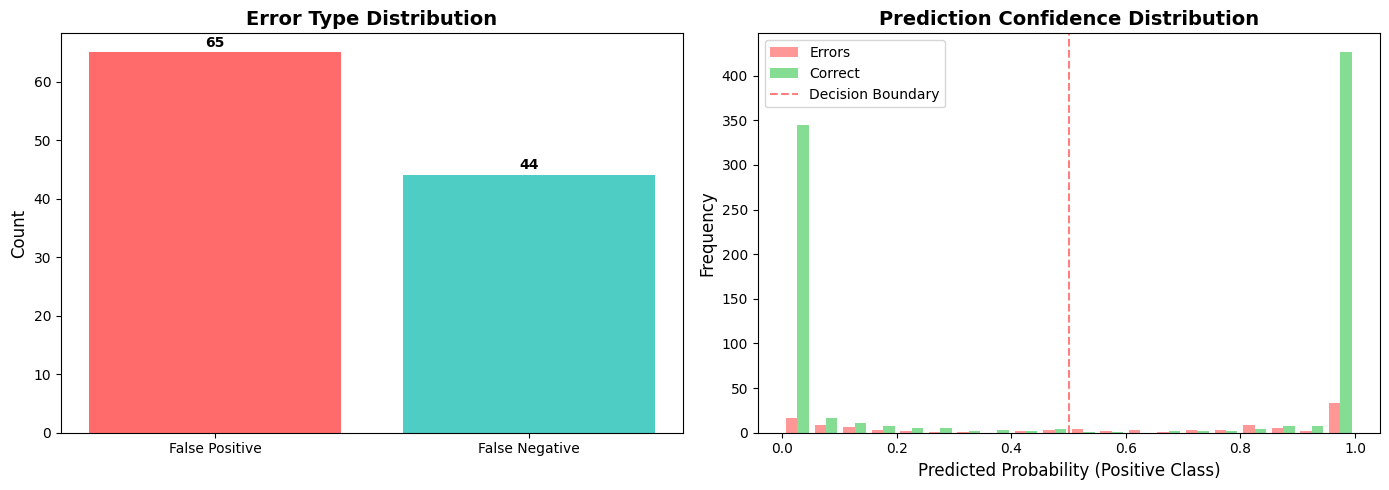

In [94]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error distribution
error_types = ['False Positive', 'False Negative']
error_counts = [len(false_positives), len(false_negatives)]
axes[0].bar(error_types, error_counts, color=['#ff6b6b', '#4ecdc4'])
axes[0].set_title('Error Type Distribution', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Count', fontsize=12)
for i, v in enumerate(error_counts):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Confidence distribution
axes[1].hist([errors_df['pred_prob'], correct_df['pred_prob']], 
             label=['Errors', 'Correct'], bins=20, alpha=0.7, color=['#ff6b6b', '#51cf66'])
axes[1].set_title('Prediction Confidence Distribution', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Predicted Probability (Positive Class)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Decision Boundary')
axes[1].legend()

plt.tight_layout()
plt.show()

1. **Consolidated Results**  
   - How do you compare models with different architectures (e.g., logistic regression vs. BERT) to select the best model for deployment?
   1. Use multiple metrics. Accuracy is the overall correctness. Should also consider ROC-AUC, precision, recall and F1-scores. F1-score balanced precision and recall.
   2. Use statistical significance testing. One model performed better than the other one might be just random or luck. But a statistical test can verify if the differences are real.
   3. Compre training time. Traditional models are fast to train, but the BERT fine-tuning model needs a lot of time to train and also requires a GPU.
   4. Compre interpretability. Traditional models are more interpretable than deep learning models.

2. **Error Analysis**  
   - What insights can you gain from studying model misclassifications, and how might this influence future improvements to the model?
   1. Sarcasm is really hard for models to detect. The model interprets the positive words literally.
   2. Mixed sentiment issues. Some words have different meanings based on the context.
   3. Culture different vocabulary. Some words have different meanings based on culture. "butterfingered" is used in different situations. It could be understood differently.
   4. Some criticism are inderect. "hard for me to warm up" could be "I hate it" or have different meanings based on the words after that.

# **Part 8 – Optional Challenge Extensions (FOR BONUS POINTS)**
* Implement data augmentation for text (back-translation, synonym swapping) and measure its impact.
* Integrate a sentiment lexicon feature (e.g., VADER scores) into your models and assess whether it improves predictions.
* Deploy your best model as a simple REST API using Flask or FastAPI and demo it on a handful of user‐submitted reviews.

In [97]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.sparse import hstack, csr_matrix

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00


In [100]:
# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Function to extract VADER scores
def get_vader_scores(text):
    """
    Returns VADER sentiment scores
    Returns: [neg, neu, pos, compound] scores
    """
    scores = vader.polarity_scores(str(text))
    return [scores['neg'], scores['neu'], scores['pos'], scores['compound']]

In [101]:
# Extract VADER scores for all datasets
vader_train = np.array([get_vader_scores(text) for text in train_df["sentence"]])
vader_val = np.array([get_vader_scores(text) for text in val_df["sentence"]])
vader_test = np.array([get_vader_scores(text) for text in test_df["sentence"]])

print(f"\nVADER feature shape: {vader_train.shape}")


VADER feature shape: (7690, 4)


In [102]:
# Example VADER scores
for i in range(3):
    text = train_df["sentence"].iloc[i]
    scores = vader_train[i]
    label = train_df["label"].iloc[i]
    print(f"\nText: {text[:60]}...")
    print(f"  True label: {'Positive' if label == 1 else 'Negative'}")
    print(f"  VADER [neg, neu, pos, compound]: {scores}")


Text: there 's ... an underlying old world sexism to monday mornin...
  True label: Negative
  VADER [neg, neu, pos, compound]: [0.     0.847  0.153  0.4019]

Text: the film proves unrelentingly grim -- and equally engrossing...
  True label: Positive
  VADER [neg, neu, pos, compound]: [ 0.291   0.709   0.     -0.5719]

Text: it smacks of purely commercial motivation , with no great lo...
  True label: Negative
  VADER [neg, neu, pos, compound]: [ 0.294   0.486   0.22   -0.3987]


VADER-Only Classifier

In [103]:
# Train logistic regression on VADER features only
lr_vader_only = LogisticRegression(max_iter=1000, random_state=42)
lr_vader_only.fit(vader_train, y_train)

# Predictions
y_pred_vader = lr_vader_only.predict(vader_test)
y_prob_vader = lr_vader_only.predict_proba(vader_test)[:, 1]

# Evaluate
vader_only_results = {
    "Model": "VADER-Only (Logistic Regression)",
    "Accuracy": accuracy_score(y_test, y_pred_vader),
    "Precision": precision_score(y_test, y_pred_vader),
    "Recall": recall_score(y_test, y_pred_vader),
    "F1": f1_score(y_test, y_pred_vader),
    "ROC-AUC": roc_auc_score(y_test, y_prob_vader)
}

print("\nVADER-Only:")
for metric, value in vader_only_results.items():
    if metric != "Model":
        print(f"  {metric}: {value:.4f}")


VADER-Only:
  Accuracy: 0.6830
  Precision: 0.6875
  Recall: 0.7082
  F1: 0.6977
  ROC-AUC: 0.7554


TF-IDF + VADER

In [104]:
# Load TF-IDF features from Part 3
try:
    import joblib
    tfidf = joblib.load("tfidf_vectorizer.joblib")
    X_train_tfidf = tfidf.transform(train_df["clean_text"])
    X_val_tfidf = tfidf.transform(val_df["clean_text"])
    X_test_tfidf = tfidf.transform(test_df["clean_text"])
    print("Loaded existing TF-IDF vectorizer")
except:
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_train_tfidf = tfidf.fit_transform(train_df["clean_text"])
    X_val_tfidf = tfidf.transform(val_df["clean_text"])
    X_test_tfidf = tfidf.transform(test_df["clean_text"])
    print("Created new TF-IDF features")

# Combine TF-IDF + VADER
X_train_combined = hstack([X_train_tfidf, csr_matrix(vader_train)])
X_test_combined = hstack([X_test_tfidf, csr_matrix(vader_test)])

print(f"\nCombined feature shape: {X_train_combined.shape}")
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"VADER features: {vader_train.shape[1]}")
print(f"Total: {X_train_combined.shape[1]}")

# Train Logistic Regression on combined features
lr_combined = LogisticRegression(max_iter=2000, random_state=42)
lr_combined.fit(X_train_combined, y_train)

y_pred_combined = lr_combined.predict(X_test_combined)
y_prob_combined = lr_combined.predict_proba(X_test_combined)[:, 1]

combined_results = {
    "Model": "TF-IDF + VADER (Logistic Regression)",
    "Accuracy": accuracy_score(y_test, y_pred_combined),
    "Precision": precision_score(y_test, y_pred_combined),
    "Recall": recall_score(y_test, y_pred_combined),
    "F1": f1_score(y_test, y_pred_combined),
    "ROC-AUC": roc_auc_score(y_test, y_prob_combined)
}

print("\nTF-IDF + VADER Combined:")
for metric, value in combined_results.items():
    if metric != "Model":
        print(f"  {metric}: {value:.4f}")

Loaded existing TF-IDF vectorizer

Combined feature shape: (7690, 5004)
TF-IDF features: 5000
VADER features: 4
Total: 5004

TF-IDF + VADER Combined:
  Accuracy: 0.7900
  Precision: 0.7944
  Recall: 0.8008
  F1: 0.7976
  ROC-AUC: 0.8819


Compare Baseline

In [105]:
# Train baseline (TF-IDF only)
lr_baseline = LogisticRegression(max_iter=2000, random_state=42)
lr_baseline.fit(X_train_tfidf, y_train)

y_pred_baseline = lr_baseline.predict(X_test_tfidf)
y_prob_baseline = lr_baseline.predict_proba(X_test_tfidf)[:, 1]

baseline_results = {
    "Model": "TF-IDF Only (Logistic Regression)",
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "Precision": precision_score(y_test, y_pred_baseline),
    "Recall": recall_score(y_test, y_pred_baseline),
    "F1": f1_score(y_test, y_pred_baseline),
    "ROC-AUC": roc_auc_score(y_test, y_prob_baseline)
}

print("\nBaseline (TF-IDF Only) Performance:")
for metric, value in baseline_results.items():
    if metric != "Model":
        print(f"  {metric}: {value:.4f}")


Baseline (TF-IDF Only) Performance:
  Accuracy: 0.7942
  Precision: 0.7926
  Recall: 0.8149
  F1: 0.8036
  ROC-AUC: 0.8720


Result Comparison

In [106]:
comparison_df = pd.DataFrame([
    baseline_results,
    vader_only_results,
    combined_results
])

print(comparison_df.to_string(index=False))

                               Model  Accuracy  Precision   Recall       F1  ROC-AUC
   TF-IDF Only (Logistic Regression)  0.794179   0.792564 0.814889 0.803571 0.872006
    VADER-Only (Logistic Regression)  0.682952   0.687500 0.708249 0.697721 0.755444
TF-IDF + VADER (Logistic Regression)  0.790021   0.794411 0.800805 0.797595 0.881881


In [108]:
# Improvement
acc_improvement = combined_results["Accuracy"] - baseline_results["Accuracy"]
roc_improvement = combined_results["ROC-AUC"] - baseline_results["ROC-AUC"]

print(f"Accuracy improvement: {acc_improvement:+.4f} ({acc_improvement*100:+.2f}%)")
print(f"ROC-AUC improvement: {roc_improvement:+.4f} ({roc_improvement*100:+.2f}%)")

Accuracy improvement: -0.0042 (-0.42%)
ROC-AUC improvement: +0.0099 (+0.99%)


In [109]:
# VADER feature importance Coefficients
vader_coefs = lr_combined.coef_[0][-4:]
vader_features = ['negative', 'neutral', 'positive', 'compound']

print("Logistic Regression Coefficients for VADER features:")
for feat, coef in zip(vader_features, vader_coefs):
    print(f"  {feat:10s}: {coef:+.4f}")

Logistic Regression Coefficients for VADER features:
  negative  : -2.8857
  neutral   : -0.4669
  positive  : +3.3547
  compound  : +0.8168


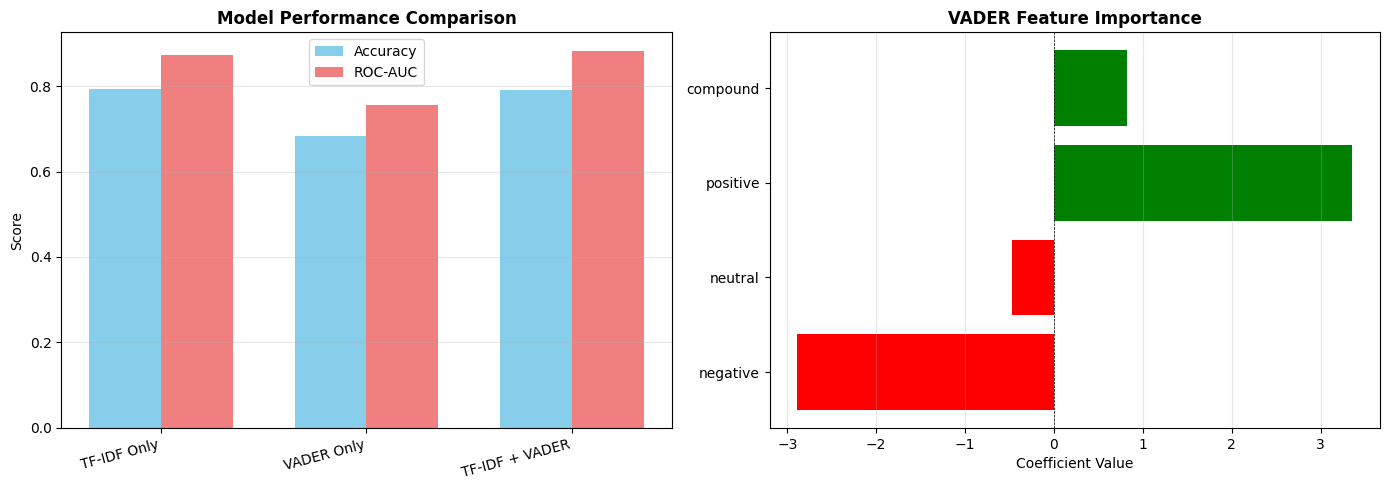

In [110]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
models = ['TF-IDF Only', 'VADER Only', 'TF-IDF + VADER']
accuracies = [baseline_results['Accuracy'], vader_only_results['Accuracy'], combined_results['Accuracy']]
roc_aucs = [baseline_results['ROC-AUC'], vader_only_results['ROC-AUC'], combined_results['ROC-AUC']]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
axes[0].bar(x + width/2, roc_aucs, width, label='ROC-AUC', color='lightcoral')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# VADER feature coefficients
axes[1].barh(vader_features, vader_coefs, color=['red' if c < 0 else 'green' for c in vader_coefs])
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('VADER Feature Importance', fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.5)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [111]:
# Save
comparison_df.to_csv("part8_2_vader_results.csv", index=False)

Data augmentation for test

In [112]:
!pip install nlpaug googletrans==3.1.0a0
!pip install nltk

import nltk
import random
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

from nltk.corpus import wordnet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=f4c14998bb6bff4e77e8d4aac6346ad6f21a6761a20ea57920b0d3214080d818
  Stored in directory: /root/.cache/pip/wheels/81/f2/e0/d578821d723b473d18610ea93810e4a5402463919f07e603d9
Successfully built googletrans
  Attempting uninstal

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Synonym Replacement

In [113]:
def get_synonyms(word):
    """Get synonyms for a word using WordNet"""
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(text, n=2):
    """
    Replace n random words with their synonyms
    Args:
        text: input text
        n: number of words to replace
    """
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalnum()]))
    random.shuffle(random_word_list)
    
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    
    return ' '.join(new_words)

# Test replacement
print("Testing Synonym Replacement:")
test_texts = [
    "This movie is amazing and wonderful",
    "The film was terrible and boring",
    "A great performance by the actors"
]

for text in test_texts:
    augmented = synonym_replacement(text, n=2)
    print(f"\nOriginal:   {text}")
    print(f"Augmented:  {augmented}")

Testing Synonym Replacement:

Original:   This movie is amazing and wonderful
Augmented:  This motion picture embody amazing and wonderful

Original:   The film was terrible and boring
Augmented:  The moving picture cost terrible and boring

Original:   A great performance by the actors
Augmented:  A peachy performance away the actors


Random insertion/delection/swap

In [114]:
def random_insertion(text, n=1):
    """Randomly insert n synonyms into the text"""
    words = text.split()
    new_words = words.copy()
    
    for _ in range(n):
        if len(words) == 0:
            break
        random_word = random.choice(words)
        synonyms = get_synonyms(random_word)
        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            random_idx = random.randint(0, len(new_words))
            new_words.insert(random_idx, synonym)
    
    return ' '.join(new_words)

def random_deletion(text, p=0.1):
    """Randomly delete words with probability p"""
    words = text.split()
    if len(words) == 1:
        return text
    
    new_words = []
    for word in words:
        if random.random() > p:
            new_words.append(word)
    
    if len(new_words) == 0:
        return random.choice(words)
    
    return ' '.join(new_words)

def random_swap(text, n=1):
    """Randomly swap n pairs of words"""
    words = text.split()
    new_words = words.copy()
    
    for _ in range(n):
        if len(new_words) < 2:
            break
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    
    return ' '.join(new_words)

# Test
print("Testing Random Operations:")
test_text = "This movie is absolutely amazing and wonderful"

print(f"\nOriginal:       {test_text}")
print(f"Insertion:      {random_insertion(test_text, n=2)}")
print(f"Deletion (p=0.2): {random_deletion(test_text, p=0.2)}")
print(f"Swap (n=2):     {random_swap(test_text, n=2)}")

Testing Random Operations:

Original:       This movie is absolutely amazing and wonderful
Insertion:      exist This movie is absolutely amazing and picture wonderful
Deletion (p=0.2): This absolutely amazing and wonderful
Swap (n=2):     This wonderful is absolutely movie and amazing


Back-Translation

In [115]:
from googletrans import Translator

translator = Translator()

def back_translate(text, intermediate_lang='fr'):
    """
    Back-translation: English -> Intermediate Language -> English
    Args:
        text: input English text
        intermediate_lang: intermediate language code (fr, es, de, etc.)
    """
    try:
        # Translate to intermediate language
        intermediate = translator.translate(text, src='en', dest=intermediate_lang).text
        # Translate back to English
        back = translator.translate(intermediate, src=intermediate_lang, dest='en').text
        return back
    except Exception as e:
        print(f"Translation error: {e}")
        return text

In [116]:
test_samples = train_df["sentence"].sample(3, random_state=42).tolist()

for text in test_samples:
    print(f"\nOriginal (English): {text}")
    try:
        bt_french = back_translate(text, 'fr')
        print(f"Back-translated (via French): {bt_french}")
    except:
        print("  [Translation failed - skipping]")


Original (English): essentially `` fatal attraction '' remade for viewers who were in diapers when the original was released in 1987 .
Back-translated (via French): essentially a "Fatal Attraction" remade for viewers who were in diapers when the original was released in 1987.

Original (English): atom egoyan has conjured up a multilayered work that tackles any number of fascinating issues
Back-translated (via French): Atom Egoyan has imagined a multi-layered work that addresses a number of fascinating questions.

Original (English): poetry in motion captured on film .
Back-translated (via French): poetry in motion captured on film.


**APPLY Augmentation**

In [117]:
def augment_text(text, technique='synonym'):
    """Apply one random augmentation technique"""
    techniques = {
        'synonym': lambda t: synonym_replacement(t, n=2),
        'insert': lambda t: random_insertion(t, n=1),
        'delete': lambda t: random_deletion(t, p=0.1),
        'swap': lambda t: random_swap(t, n=2)
    }
    
    if technique == 'all':
        # Randomly choose
        technique = random.choice(list(techniques.keys()))
    
    return techniques[technique](text)

# Create augmented dataset
# 1: Augment a subset of training data
augment_ratio = 0.3  # Augment 30% of training data
n_augment = int(len(train_df) * augment_ratio)

print(f"\nCreating {n_augment} augmented samples...")

augmented_samples = []
for i in range(n_augment):
    # Sample random text
    idx = random.randint(0, len(train_df) - 1)
    original_text = train_df.iloc[idx]["sentence"]
    label = train_df.iloc[idx]["label"]
    
    # Apply random augmentation
    aug_text = augment_text(original_text, technique='all')
    augmented_samples.append({
        'sentence': aug_text,
        'label': label,
        'augmented': True
    })

# Create augmented dataframe
augmented_df = pd.DataFrame(augmented_samples)

# Mark original data
train_df_marked = train_df.copy()
train_df_marked['augmented'] = False

# Combine original + augmented
train_augmented = pd.concat([train_df_marked, augmented_df], ignore_index=True)

print(f"\nOriginal training size: {len(train_df)}")
print(f"Augmented samples added: {len(augmented_df)}")
print(f"New training size: {len(train_augmented)}")


Creating 2307 augmented samples...

Original training size: 7690
Augmented samples added: 2307
New training size: 9997


In [118]:
# Exampole
for i in range(5):
    orig_idx = random.randint(0, len(train_df) - 1)
    original = train_df.iloc[orig_idx]["sentence"]
    label = train_df.iloc[orig_idx]["label"]
    
    aug_synonym = synonym_replacement(original, n=2)
    aug_swap = random_swap(original, n=1)
    
    print(f"\n[Example {i+1}] Label: {'Positive' if label == 1 else 'Negative'}")
    print(f"Original:  {original}")
    print(f"Synonym:   {aug_synonym}")
    print(f"Swap:      {aug_swap}")


[Example 1] Label: Positive
Original:  diggs and lathan are among the chief reasons brown sugar is such a sweet and sexy film .
Synonym:   diggs and lathan be among the chief reasons brown sugar is such a sweet and aphrodisiacal film .
Swap:      diggs and lathan are among the chief reasons brown sexy is such a sweet and sugar film .

[Example 2] Label: Positive
Original:  for benigni it was n't shakespeare whom he wanted to define his career with but pinocchio .
Synonym:   for benigni it was n't Bard of Avon whom he wanted to define his calling with but pinocchio .
Swap:      for benigni it was n't shakespeare whom he wanted to pinocchio his career with but define .

[Example 3] Label: Positive
Original:  the cast , collectively a successful example of the lovable-loser protagonist , shows deft comic timing .
Synonym:   the plaster bandage , collectively a successful example of the lovable-loser admirer , shows deft comic timing .
Swap:      the cast a collectively , successful examp

Training with agumented data

In [119]:
import re
import string

def basic_clean(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r"<.*?>", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

train_augmented["clean_text"] = train_augmented["sentence"].apply(basic_clean)

# Create TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_aug = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_aug_tfidf = tfidf_aug.fit_transform(train_augmented["clean_text"])
y_train_aug = train_augmented["label"].values

# Test set
X_test_tfidf_aug = tfidf_aug.transform(test_df["clean_text"])

print(f"Augmented training features shape: {X_train_aug_tfidf.shape}")

# Train model on augmented data
lr_augmented = LogisticRegression(max_iter=2000, random_state=42)
lr_augmented.fit(X_train_aug_tfidf, y_train_aug)

y_pred_aug = lr_augmented.predict(X_test_tfidf_aug)
y_prob_aug = lr_augmented.predict_proba(X_test_tfidf_aug)[:, 1]

augmented_results = {
    "Model": "Logistic Regression (Augmented Data)",
    "Accuracy": accuracy_score(y_test, y_pred_aug),
    "Precision": precision_score(y_test, y_pred_aug),
    "Recall": recall_score(y_test, y_pred_aug),
    "F1": f1_score(y_test, y_pred_aug),
    "ROC-AUC": roc_auc_score(y_test, y_prob_aug)
}

# Train baseline
tfidf_baseline = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_baseline = tfidf_baseline.fit_transform(train_df["clean_text"])
X_test_baseline = tfidf_baseline.transform(test_df["clean_text"])

lr_baseline_aug = LogisticRegression(max_iter=2000, random_state=42)
lr_baseline_aug.fit(X_train_baseline, y_train)

y_pred_baseline_aug = lr_baseline_aug.predict(X_test_baseline)
y_prob_baseline_aug = lr_baseline_aug.predict_proba(X_test_baseline)[:, 1]

baseline_aug_results = {
    "Model": "Logistic Regression (Original Data)",
    "Accuracy": accuracy_score(y_test, y_pred_baseline_aug),
    "Precision": precision_score(y_test, y_pred_baseline_aug),
    "Recall": recall_score(y_test, y_pred_baseline_aug),
    "F1": f1_score(y_test, y_pred_baseline_aug),
    "ROC-AUC": roc_auc_score(y_test, y_prob_baseline_aug)
}

Augmented training features shape: (9997, 5000)


Comparison

In [121]:
comparison_aug = pd.DataFrame([baseline_aug_results, augmented_results])
print(comparison_aug.to_string(index=False))

                               Model  Accuracy  Precision   Recall       F1  ROC-AUC
 Logistic Regression (Original Data)  0.794179   0.792564 0.814889 0.803571 0.872006
Logistic Regression (Augmented Data)  0.793139   0.791016 0.814889 0.802775 0.871803


In [122]:
# Improvement
acc_improvement = augmented_results["Accuracy"] - baseline_aug_results["Accuracy"]
roc_improvement = augmented_results["ROC-AUC"] - baseline_aug_results["ROC-AUC"]

print(f"Training data increase: {len(train_df)} → {len(train_augmented)} (+{len(augmented_df)} samples, +{augment_ratio*100:.0f}%)")
print(f"Accuracy change: {acc_improvement:+.4f} ({acc_improvement*100:+.2f}%)")
print(f"ROC-AUC change: {roc_improvement:+.4f} ({roc_improvement*100:+.2f}%)")

Training data increase: 7690 → 9997 (+2307 samples, +30%)
Accuracy change: -0.0010 (-0.10%)
ROC-AUC change: -0.0002 (-0.02%)


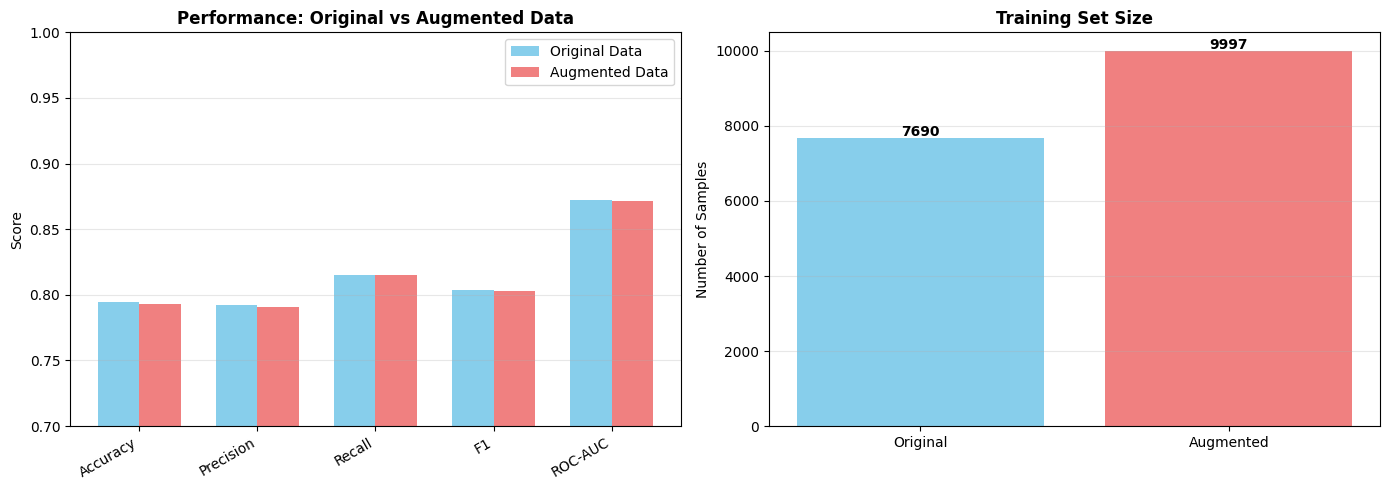

In [123]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Performance comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
baseline_scores = [baseline_aug_results[m] for m in metrics]
augmented_scores = [augmented_results[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, baseline_scores, width, label='Original Data', color='skyblue')
axes[0].bar(x + width/2, augmented_scores, width, label='Augmented Data', color='lightcoral')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance: Original vs Augmented Data', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=30, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# Training set size
axes[1].bar(['Original', 'Augmented'], 
           [len(train_df), len(train_augmented)],
           color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Training Set Size', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([len(train_df), len(train_augmented)]):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [124]:
# Save results
comparison_aug.to_csv("part8_1_augmentation_results.csv", index=False)

1. **Data Augmentation**  
   - How does back-translation or synonym swapping as text augmentation improve model generalization?
   - For back-translation: we translate the sentence to French and then translate back to English. The sentence will be different. This creates a synonym differently, but better. The sentence will express the same idea but with other words. This will also introduce noise into the dataset, since the translation is imperfect.
   - Synonym swapping will swap certain words with synonyms. The model will see more vocabulary and reduce the word-specific bias. This will also keep the sentence's semantics consistent.
   - However, for this project, the model already generalizes well. After the augmentation, performance declined. The augmented data may have brought some noise that confused the model. 

2. **Sentiment Lexicon**  
   - How might integrating sentiment lexicons like VADER improve the sentiment classification model, and what are the challenges of using lexicon-based approaches alongside machine learning models?
   - Improvement: TF-IDF has to start from scratch to learn which words are positive or negative. VADER uses a pre-trained model to score emotions. It can also emphasize emotions using punctuation and size.
   - Challenges: One of the challenge is mismatch. For example, it labels slang like “sick” as negative even when "It's sick" could be positive in movie reviews. It analyzes text at the word level, it also misses context and cannot detect sarcasm or tone.